## Notes

We are weighting based on time (more recent reports are weighted more heavily when fitting data).

We have scant data past early November, and data around that point in time is suffereing from delays in reporting.


In [1]:
import modeller
import fitter

from functions.misc import knot_fn

import casadi as ca
import numpy as np
from matplotlib import pyplot as plt
from copy import copy
import pandas as pd

## Analysis of total cases

In [2]:
def seir(t, y, p):
    return [
        -p[1]*y[0]*y[2]/sum(y),
        p[1]*y[0]*y[2]/sum(y) - p[2]*y[1],
        p[2]*y[1] - p[0]*y[2],
        p[0]*y[2]
    ]

In [3]:
cases = pd.read_csv("data/samoa_cases.csv", header=0, parse_dates=["Date"], dayfirst=True)
raw_times = cases["Date"].to_numpy()
raw_times = [(t-raw_times[0])/np.timedelta64(1,'D') for t in raw_times] # convert to days since first timestamp
raw_data = cases['Cases'].to_numpy()
raw_cumdata = np.cumsum(raw_data)

In [4]:
start = 1
clip = 5
times = raw_times[start:(-clip if clip else None)]
data = raw_data[start:(-clip if clip else None)]
cumdata = raw_cumdata[start:(-clip if clip else None)]

In [5]:
additional_times = [75,83,86,87,89,90,91]
additional_cumdata = [716,1174,1644,1797,2194,2437,2686]

times = times + additional_times
cumdata = np.concatenate([cumdata,additional_cumdata])

<BarContainer object of 57 artists>

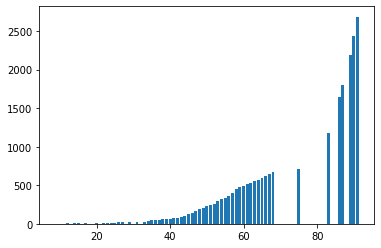

In [6]:
plt.bar(times, cumdata)

In [7]:
data_pd = np.array([[i] for i in cumdata])
p0 = [1/8, 1.5, 1/8]
config = {
    "grid_size": 100,
    "basis_number": 24,
    "model_form": {
        "state": 4,
        "parameters": 3
    },
    "time_span": [times[0], times[-1]],
    "knot_function": None,
    "model": seir,
    "dataset": {"y": data_pd, "t": np.array(times)},
    "observation_vector": [-1],
    "weightings":[
        [1]*4,
        times
    ],
    "regularisation_value": copy(p0),
}

In [8]:
model = modeller.Model(config)
config['regularisation_value'][1] = model.ps[1]
objective = fitter.Objective()
objective.make(config, config['dataset'], model)

solver_setup = {
    'f': objective.objective,
    'x': ca.vcat(objective.input_list),
    'p': ca.hcat([objective.rho, objective.alpha]),
    'g': ca.vcat(model.xs),
}

solver = ca.nlpsol('solver', 'ipopt', solver_setup)

In [9]:
f1_ex = ca.Function('f1_ex', [solver_setup['x']], [objective.obj_1])
f2_ex = ca.Function('f2_ex', [solver_setup['x']], [objective.obj_2])
getx = ca.Function('getx', [solver_setup['x']], model.xs)
getp = ca.Function('getx', [solver_setup['x']], model.ps)


In [10]:
c0 = [np.ones(config['basis_number']) for _ in range(4)]
x0 = np.hstack([*c0, p0])
lbx = [-np.inf]*(config['basis_number']*4) + [0]*len(config['regularisation_value'])
alpha = 1e2

In [11]:
pure_solve = solver(x0=x0, p=[0, 0], lbx=lbx, lbg=0)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     9600
Number of nonzeros in Lagrangian Hessian.............:     4925

Total number of variables............................:       99
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equa

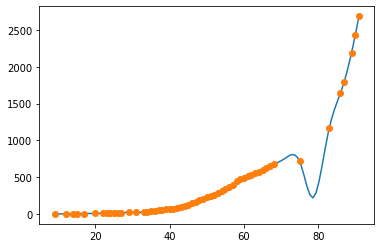

In [12]:
pure_xs = getx(pure_solve['x'])
plt.plot(model.observation_times, pure_xs[-1])
plt.plot(times, cumdata, 'o')

In [13]:
prange = np.logspace(-6, 6, num=80)
sols = []
xguess = x0
for p in prange:
    solve_opts = {
        'x0': xguess,
        'p': [p, alpha],
        'lbx': lbx,
        'ubx': 150000,
        'lbg': 0,
        'ubg': 150000
    }
    sols.append(solver(**solve_opts))
    xguess = np.array(sols[-1]['x']).flatten()

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     9600
Number of nonzeros in Lagrangian Hessian.............:     4925

Total number of variables............................:       99
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        3
                     variables with only upper bounds:       96
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      400
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      400
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  11  2.8378059e+04 0.00e+00 1.70e+01  -3.8 2.18e+04    -  6.22e-01 1.00e+00f  1
  12  2.8377898e+04 0.00e+00 5.61e+01  -3.8 2.82e+04    -  5.24e-01 1.00e+00f  1
  13  2.8377760e+04 0.00e+00 1.29e-05  -3.8 1.29e-01  -4.0 1.00e+00 1.00e+00f  1
  14  2.8377760e+04 0.00e+00 1.28e-05  -5.7 3.83e-01  -4.5 1.00e+00 1.00e+00h  1
  15  2.8377760e+04 0.00e+00 1.27e-05  -8.6 1.15e+00  -5.0 1.00e+00 1.00e+00f  1
  16  2.8377760e+04 0.00e+00 1.27e-05  -8.6 3.42e+00  -5.4 1.00e+00 1.00e+00f  1
  17  2.8377759e+04 0.00e+00 1.24e-05  -8.6 1.01e+01  -5.9 1.00e+00 1.00e+00f  1
  18  2.8377757e+04 0.00e+00 3.54e-05  -8.6 2.86e+01  -6.4 1.00e+00 1.00e+00f  1
  19  2.8377752e+04 0.00e+00 2.26e-04  -8.6 7.40e+01  -6.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  2.8377746e+04 0.00e+00 4.79e-04  -8.6 1.58e+02  -7.3 1.00e+00 6.69e-01f  1
  21  2.8377733e+04 0.00e+00 2.14e-03  -8.6 2.84e+02  -7.8 1.00e+00 1.00e+00f  1
  22  2.8377715e+04 0.00e+00

   9  2.8375772e+04 0.00e+00 3.14e+00  -2.5 3.44e+04    -  6.48e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.8375646e+04 0.00e+00 6.39e-05  -2.5 8.98e-02  -4.5 1.00e+00 1.00e+00f  1
  11  2.8375475e+04 0.00e+00 2.29e-01  -3.8 1.83e+04    -  7.70e-01 1.00e+00f  1
  12  2.8375424e+04 0.00e+00 1.39e-01  -3.8 5.50e+03    -  1.00e+00 1.00e+00f  1
  13  2.8375410e+04 0.00e+00 9.03e-02  -3.8 9.13e+03    -  1.00e+00 1.00e+00f  1
  14  2.8375408e+04 0.00e+00 2.16e-02  -3.8 1.41e+04    -  1.00e+00 1.00e+00f  1
  15  2.8375407e+04 0.00e+00 3.29e-02  -3.8 2.32e+04    -  9.87e-01 1.00e+00f  1
  16  2.8375407e+04 0.00e+00 5.48e-04  -3.8 5.45e+03    -  1.00e+00 1.00e+00f  1
  17  2.8375398e+04 0.00e+00 4.73e-02  -5.7 1.97e+03    -  9.19e-01 1.00e+00f  1
  18  2.8375396e+04 0.00e+00 1.48e-02  -5.7 2.00e+03    -  1.00e+00 1.00e+00f  1
  19  2.8375395e+04 0.00e+00 3.06e-03  -5.7 6.28e+03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

  12  2.8375427e+04 0.00e+00 2.56e-01  -3.8 3.70e+03    -  9.82e-01 1.00e+00f  1
  13  2.8375410e+04 0.00e+00 1.44e-01  -3.8 7.76e+03    -  1.00e+00 1.00e+00f  1
  14  2.8375410e+04 0.00e+00 1.11e-02  -3.8 1.41e+04    -  1.00e+00 1.00e+00f  1
  15  2.8375410e+04 0.00e+00 6.33e-02  -3.8 2.54e+04    -  1.00e+00 1.00e+00f  1
  16  2.8375409e+04 0.00e+00 4.90e-04  -3.8 6.54e+03    -  1.00e+00 1.00e+00f  1
  17  2.8375401e+04 0.00e+00 5.51e-02  -5.7 1.59e+03    -  8.99e-01 1.00e+00f  1
  18  2.8375399e+04 0.00e+00 1.55e-02  -5.7 2.26e+03    -  1.00e+00 1.00e+00f  1
  19  2.8375398e+04 0.00e+00 4.27e-03  -5.7 5.07e+03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  2.8375398e+04 0.00e+00 9.31e-03  -5.7 1.33e+05    -  5.13e-01 1.36e-01f  3
  21  2.8375397e+04 0.00e+00 2.93e-03  -5.7 9.40e+03    -  1.00e+00 1.00e+00f  1
  22  2.8375397e+04 0.00e+00 1.76e-03  -5.7 3.15e+03    -  1.00e+00 1.00e+00f  1
  23  2.8375397e+04 0.00e+00

  57  2.8375400e+04 0.00e+00 7.66e-03  -9.0 1.15e+03    -  1.00e+00 1.00e+00f  1
  58  2.8375400e+04 0.00e+00 7.77e-03  -9.0 1.03e+03    -  1.00e+00 1.00e+00f  1
  59  2.8375400e+04 0.00e+00 8.25e-03  -9.0 9.37e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  2.8375400e+04 0.00e+00 7.83e-03  -9.0 8.11e+02    -  1.00e+00 1.00e+00f  1
  61  2.8375400e+04 0.00e+00 9.69e-03  -9.0 8.11e+02    -  1.00e+00 1.00e+00f  1
  62  2.8375400e+04 0.00e+00 6.49e-03  -9.0 5.82e+02    -  1.00e+00 1.00e+00f  1
  63  2.8375400e+04 0.00e+00 1.84e-02  -9.0 9.17e+02    -  1.00e+00 1.00e+00f  1
  64  2.8375400e+04 0.00e+00 1.82e-03  -9.0 2.09e+02    -  1.00e+00 1.00e+00f  1
  65  2.8375400e+04 0.00e+00 1.86e-02  -9.0 6.91e+03    -  1.00e+00 1.09e-01f  3
  66  2.8375400e+04 0.00e+00 2.27e-03  -9.0 2.06e+02    -  1.00e+00 1.00e+00f  1
  67  2.8375400e+04 0.00e+00 1.63e-02  -9.0 4.16e+03    -  1.00e+00 1.41e-01f  3
  68  2.8375400e+04 0.00e+00

  34  2.8375406e+04 0.00e+00 3.62e-06  -8.6 1.04e+02 -12.6 1.00e+00 1.00e+00h  1
  35  2.8375406e+04 0.00e+00 3.41e-05  -8.6 3.19e+02 -13.1 1.00e+00 1.00e+00h  1
  36  2.8375406e+04 0.00e+00 3.53e-04  -8.6 1.00e+03 -13.5 1.00e+00 1.00e+00h  1
  37  2.8375406e+04 0.00e+00 4.74e-03  -8.6 3.44e+03 -14.0 1.00e+00 1.00e+00h  1
  38  2.8375406e+04 0.00e+00 1.07e-02  -8.6 8.20e+03    -  1.00e+00 5.00e-01h  2
  39  2.8375406e+04 0.00e+00 4.56e-03  -8.6 2.54e+03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  2.8375406e+04 0.00e+00 1.37e-02  -8.6 6.83e+03    -  1.00e+00 5.00e-01f  2
  41  2.8375406e+04 0.00e+00 3.07e-03  -8.6 1.44e+03    -  1.00e+00 1.00e+00f  1
  42  2.8375406e+04 0.00e+00 1.47e-02  -8.6 1.09e+04    -  1.00e+00 2.50e-01f  3
  43  2.8375406e+04 0.00e+00 3.18e-03  -8.6 1.13e+03    -  1.00e+00 1.00e+00f  1
  44  2.8375406e+04 0.00e+00 1.56e-02  -8.6 8.71e+03    -  1.00e+00 2.50e-01f  3
  45  2.8375406e+04 0.00e+00

  25  2.8375414e+04 0.00e+00 3.26e-02  -8.6 7.93e+03    -  1.00e+00 8.86e-01f  1
  26  2.8375413e+04 0.00e+00 7.96e-04  -8.6 5.22e+01  -9.2 1.00e+00 1.00e+00f  1
  27  2.8375413e+04 0.00e+00 2.04e-04  -8.6 1.09e+02  -9.7 1.00e+00 1.00e+00f  1
  28  2.8375413e+04 0.00e+00 4.95e-04  -8.6 1.82e+02 -10.2 1.00e+00 1.00e+00f  1
  29  2.8375413e+04 0.00e+00 3.15e-04  -8.6 1.50e+02 -10.7 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  2.8375413e+04 0.00e+00 3.57e-05  -8.6 5.02e+01 -11.2 1.00e+00 1.00e+00h  1
  31  2.8375413e+04 0.00e+00 6.19e-07  -8.6 1.06e+01 -11.6 8.02e-01 1.00e+00h  1
  32  2.8375413e+04 0.00e+00 6.83e-08  -8.6 2.35e+01 -12.1 4.38e-01 1.00e+00h  1
  33  2.8375413e+04 0.00e+00 7.63e-07  -8.6 7.00e+01 -12.6 1.00e+00 1.00e+00h  1
  34  2.8375413e+04 0.00e+00 6.98e-06  -8.6 2.11e+02 -13.1 1.00e+00 1.00e+00h  1
  35  2.8375413e+04 0.00e+00 6.70e-05  -8.6 6.49e+02 -13.5 1.00e+00 1.00e+00h  1
  36  2.8375413e+04 0.00e+00

  12  2.8375731e+04 0.00e+00 1.14e+00  -2.5 1.18e+04    -  1.00e+00 1.00e+00f  1
  13  2.8375715e+04 0.00e+00 3.19e-01  -2.5 1.76e+04    -  8.92e-01 1.00e+00f  1
  14  2.8375693e+04 0.00e+00 1.68e-01  -2.5 1.56e+04    -  1.00e+00 1.00e+00f  1
  15  2.8375694e+04 0.00e+00 5.64e-04  -2.5 2.20e+03    -  1.00e+00 1.00e+00f  1
  16  2.8375479e+04 0.00e+00 8.01e-01  -3.8 3.81e+03    -  9.16e-01 1.00e+00f  1
  17  2.8375449e+04 0.00e+00 8.57e-02  -3.8 2.69e+03    -  1.00e+00 1.00e+00f  1
  18  2.8375439e+04 0.00e+00 4.92e-02  -3.8 1.49e+03    -  1.00e+00 1.00e+00f  1
  19  2.8375437e+04 0.00e+00 7.50e-03  -3.8 6.55e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  2.8375436e+04 0.00e+00 1.27e-03  -3.8 1.47e+02    -  1.00e+00 1.00e+00f  1
  21  2.8375428e+04 0.00e+00 1.00e-01  -5.7 1.04e+03    -  8.24e-01 1.00e+00f  1
  22  2.8375425e+04 0.00e+00 2.02e-02  -5.7 9.54e+02    -  1.00e+00 1.00e+00f  1
  23  2.8375424e+04 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.8375433e+04 0.00e+00 4.02e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  2.8375438e+04 0.00e+00 1.00e-02  -1.0 1.05e-01    -  9.90e-01 1.00e+00f  1
   2  2.8375454e+04 0.00e+00 1.14e-02  -1.0 1.42e+01    -  9.89e-01 1.00e+00f  1
   3  2.8376265e+04 0.00e+00 3.45e+00  -1.0 5.61e+03    -  1.86e-01 1.45e-01f  1
   4  2.8377959e+04 0.00e+00 6.52e+00  -1.0 1.59e+04    -  9.85e-03 2.50e-01f  3
   5  2.8376356e+04 0.00e+00 3.16e-02  -1.0 5.05e+00  -4.0 9.98e-01 1.00e+00f  1
   6  2.8375623e+04 0.00e+00 9.20e-01  -2.5 3.21e+03    -  7.60e-01 1.00e+00f  1
   7  2.8375528e+04 0.00e+00 4.03e-02  -2.5 2.01e+03    -  8.03e-01 1.00e+00f  1
   8  2.8375522e+04 0.00e+00 3.34e-01  -2.5 6.19e+03    -  7.83e-01 1.00e+00f  1
   9  2.8375695e+04 0.00e+00 2.46e+00  -2.5 9.68e+03    -  5.11e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.8375875e+04 0.00e+00

   8  2.8375531e+04 0.00e+00 3.46e-01  -2.5 4.71e+03    -  5.58e-01 1.00e+00f  1
   9  2.8375592e+04 0.00e+00 1.01e+00  -2.5 4.99e+03    -  7.07e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.8375703e+04 0.00e+00 1.12e+00  -2.5 6.33e+03    -  7.25e-01 1.00e+00f  1
  11  2.8375753e+04 0.00e+00 2.29e+00  -2.5 2.83e+03    -  1.00e+00 1.00e+00f  1
  12  2.8375783e+04 0.00e+00 1.62e-01  -2.5 6.29e+03    -  8.71e-01 1.00e+00f  1
  13  2.8375782e+04 0.00e+00 1.50e+00  -2.5 1.30e+04    -  6.98e-01 5.00e-01f  2
  14  2.8375758e+04 0.00e+00 6.18e-01  -2.5 1.32e+04    -  1.00e+00 1.00e+00f  1
  15  2.8375730e+04 0.00e+00 6.73e-01  -2.5 1.91e+04    -  9.70e-01 1.00e+00f  1
  16  2.8375727e+04 0.00e+00 5.16e-02  -2.5 1.34e+04    -  1.00e+00 1.00e+00f  1
  17  2.8375725e+04 0.00e+00 5.83e-04  -2.5 6.71e+02    -  1.00e+00 1.00e+00f  1
  18  2.8375519e+04 0.00e+00 9.57e-01  -3.8 2.62e+03    -  8.92e-01 1.00e+00f  1
  19  2.8375488e+04 0.00e+00

   8  2.8375611e+04 0.00e+00 1.26e+00  -2.5 3.53e+03    -  7.30e-01 1.00e+00f  1
   9  2.8375722e+04 0.00e+00 1.75e+00  -2.5 4.36e+03    -  6.79e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.8375761e+04 0.00e+00 1.57e+00  -2.5 2.06e+03    -  1.00e+00 1.00e+00f  1
  11  2.8375777e+04 0.00e+00 1.95e+00  -2.5 2.48e+03    -  8.97e-01 1.00e+00f  1
  12  2.8375789e+04 0.00e+00 7.79e-01  -2.5 4.45e+03    -  1.00e+00 1.00e+00f  1
  13  2.8375804e+04 0.00e+00 2.20e+00  -2.5 8.00e+03    -  8.29e-01 1.00e+00f  1
  14  2.8375819e+04 0.00e+00 6.43e-01  -2.5 1.41e+04    -  1.00e+00 1.00e+00f  1
  15  2.8375802e+04 0.00e+00 2.72e+00  -2.5 3.60e+04    -  6.22e-01 1.00e+00f  1
  16  2.8375817e+04 0.00e+00 9.98e-01  -2.5 2.17e+03    -  1.00e+00 1.00e+00f  1
  17  2.8375738e+04 0.00e+00 7.47e-02  -2.5 2.51e+03    -  1.00e+00 1.00e+00f  1
  18  2.8375752e+04 0.00e+00 1.15e-01  -2.5 4.11e+02    -  1.00e+00 1.00e+00f  1
  19  2.8375753e+04 0.00e+00

   5  2.8375744e+04 0.00e+00 4.64e-01  -1.7 1.92e+03    -  8.21e-01 1.00e+00f  1
   6  2.8375857e+04 0.00e+00 3.87e-01  -1.7 8.94e+03    -  5.75e-01 1.00e+00f  1
   7  2.8379069e+04 0.00e+00 3.41e+01  -1.7 8.67e+03    -  3.33e-01 1.00e+00f  1
   8  2.8376312e+04 0.00e+00 7.59e-02  -1.7 4.01e+00  -4.5 1.00e+00 1.00e+00f  1
   9  2.8375955e+04 0.00e+00 6.15e+00  -2.5 3.54e+03    -  6.60e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.8375820e+04 0.00e+00 3.87e+00  -2.5 2.22e+04    -  3.82e-01 1.68e-01f  2
  11  2.8375780e+04 0.00e+00 5.13e-01  -2.5 1.54e+03    -  8.46e-01 1.00e+00f  1
  12  2.8375832e+04 0.00e+00 1.68e+00  -2.5 3.73e+03    -  9.19e-01 1.00e+00f  1
  13  2.8375838e+04 0.00e+00 6.61e-01  -2.5 4.92e+03    -  1.00e+00 1.00e+00f  1
  14  2.8375854e+04 0.00e+00 2.57e+00  -2.5 8.83e+03    -  8.01e-01 1.00e+00f  1
  15  2.8375948e+04 0.00e+00 3.85e+00  -2.5 1.79e+04    -  1.00e+00 1.00e+00f  1
  16  2.8375917e+04 0.00e+00

   3  2.8378615e+04 0.00e+00 1.39e+01  -1.0 6.08e+03    -  1.49e-01 1.43e-01f  1
   4  2.8375959e+04 0.00e+00 3.86e-01  -1.0 1.38e+01  -4.0 9.96e-01 1.00e+00f  1
   5  2.8375819e+04 0.00e+00 6.52e-01  -1.7 1.97e+03    -  7.99e-01 1.00e+00f  1
   6  2.8375933e+04 0.00e+00 5.17e-01  -1.7 7.60e+03    -  6.29e-01 1.00e+00f  1
   7  2.8376717e+04 0.00e+00 1.52e+01  -1.7 7.79e+03    -  2.64e-01 5.00e-01f  2
   8  2.8376139e+04 0.00e+00 2.74e-02  -1.7 3.21e+00  -4.5 1.00e+00 1.00e+00f  1
   9  2.8375848e+04 0.00e+00 5.38e+00  -3.8 3.84e+03    -  6.71e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.8375732e+04 0.00e+00 1.05e+00  -3.8 5.20e+03    -  8.76e-01 1.00e+00f  1
  11  2.8375715e+04 0.00e+00 3.21e-04  -3.8 2.81e+00  -5.0 1.00e+00 1.00e+00f  1
  12  2.8375713e+04 0.00e+00 1.72e-04  -5.7 7.02e+00  -5.4 1.00e+00 1.00e+00f  1
  13  2.8375708e+04 0.00e+00 1.01e-03  -5.7 1.42e+01  -5.9 1.00e+00 1.00e+00f  1
  14  2.8375699e+04 0.00e+00

  14  2.8375847e+04 0.00e+00 3.00e+00  -3.8 9.35e+03    -  8.04e-01 2.04e-01f  1
  15  2.8375748e+04 0.00e+00 1.22e+00  -3.8 1.74e+04    -  2.86e-01 2.75e-01f  2
  16  2.8375717e+04 0.00e+00 3.19e-02  -3.8 8.07e+01  -6.9 1.00e+00 1.00e+00f  1
  17  2.8375702e+04 0.00e+00 1.54e-02  -3.8 1.13e+02  -7.3 1.00e+00 1.00e+00f  1
  18  2.8375693e+04 0.00e+00 1.33e-02  -3.8 1.22e+02  -7.8 1.00e+00 1.00e+00f  1
  19  2.8375687e+04 0.00e+00 7.18e-03  -3.8 1.53e+02  -8.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  2.8375687e+04 0.00e+00 2.11e-01  -3.8 6.32e+03    -  2.35e-01 6.25e-02f  5
  21  2.8375671e+04 0.00e+00 5.29e-02  -3.8 1.16e+03    -  1.00e+00 1.00e+00f  1
  22  2.8375672e+04 0.00e+00 1.34e-02  -3.8 8.47e+01  -8.8 1.00e+00 1.00e+00f  1
  23  2.8375673e+04 0.00e+00 2.88e-01  -3.8 3.94e+03    -  5.09e-01 1.25e-01f  4
  24  2.8375674e+04 0.00e+00 4.91e-02  -3.8 3.27e+02    -  1.00e+00 1.00e+00f  1
  25  2.8375675e+04 0.00e+00

   2  2.8375842e+04 0.00e+00 7.50e-02  -1.0 2.90e+01    -  9.86e-01 1.00e+00f  1
   3  2.8381664e+04 0.00e+00 2.81e+01  -1.0 5.92e+03    -  1.38e-01 1.59e-01f  1
   4  2.8376407e+04 0.00e+00 9.36e-01  -1.0 1.74e+01  -4.0 9.96e-01 1.00e+00f  1
   5  2.8376081e+04 0.00e+00 1.53e+00  -1.7 2.08e+03    -  7.68e-01 1.00e+00f  1
   6  2.8376229e+04 0.00e+00 2.93e+00  -1.7 5.95e+03    -  5.99e-01 1.00e+00f  1
   7  2.8377098e+04 0.00e+00 1.84e+01  -1.7 1.08e+04    -  7.91e-02 1.14e-01f  2
   8  2.8376371e+04 0.00e+00 5.13e-02  -1.7 5.21e+00  -4.5 1.00e+00 1.00e+00f  1
   9  2.8376148e+04 0.00e+00 3.78e+00  -2.5 1.63e+03    -  6.31e-01 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.8376021e+04 0.00e+00 2.08e+00  -2.5 8.63e+02    -  1.00e+00 1.00e+00f  1
  11  2.8376064e+04 0.00e+00 2.87e+00  -2.5 1.17e+03    -  8.51e-01 5.00e-01f  2
  12  2.8376092e+04 0.00e+00 8.48e-01  -2.5 1.95e+03    -  1.00e+00 1.00e+00f  1
  13  2.8376141e+04 0.00e+00

   8  2.8378339e+04 0.00e+00 1.17e+00  -1.0 3.09e+01  -5.0 1.00e+00 1.00e+00f  1
   9  2.8383697e+04 0.00e+00 2.97e+02  -1.0 1.80e+04    -  5.54e-01 6.87e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.8379738e+04 0.00e+00 5.97e+01  -1.0 5.32e+01  -5.4 1.38e-01 1.00e+00f  1
  11  2.8388626e+04 0.00e+00 2.05e+02  -1.0 1.61e+04    -  4.66e-01 5.00e-01f  2
  12  2.8380438e+04 0.00e+00 6.91e+00  -1.0 2.56e+02  -5.9 1.00e+00 1.00e+00f  1
  13  2.8381241e+04 0.00e+00 8.24e+01  -1.0 1.40e+04    -  4.14e-01 2.47e-01f  3
  14  2.8380424e+04 0.00e+00 2.43e+00  -1.0 2.13e+02  -6.4 1.00e+00 1.00e+00f  1
  15  2.8385536e+04 0.00e+00 2.55e+02  -1.0 1.17e+04    -  4.13e-01 4.14e-01f  2
  16  2.8379923e+04 0.00e+00 2.25e+01  -1.0 5.38e+02  -6.9 1.00e+00 1.00e+00f  1
  17  2.8383085e+04 0.00e+00 3.17e+02  -1.0 3.21e+04    -  2.34e-01 1.64e-01f  2
  18  2.8379314e+04 0.00e+00 3.69e+01  -1.0 8.42e+02  -7.3 1.00e+00 1.00e+00f  1
  19  2.8380943e+04 0.00e+00

 103  2.8378036e+04 0.00e+00 2.10e+01  -2.5 2.84e+03 -11.2 1.00e+00 1.00e+00f  1
 104  2.8378031e+04 0.00e+00 9.31e+00  -2.5 1.34e+03 -10.7 1.00e+00 5.00e-01f  2
 105  2.8378029e+04 0.00e+00 6.50e+00  -2.5 1.44e+03    -  1.00e+00 1.00e+00f  1
 106  2.8378027e+04 0.00e+00 2.91e+00  -2.5 8.66e+02    -  1.00e+00 1.00e+00f  1
 107  2.8378025e+04 0.00e+00 1.27e+00  -2.5 4.57e+02    -  1.00e+00 1.00e+00f  1
 108  2.8378025e+04 0.00e+00 3.43e-01  -2.5 2.22e+02    -  1.00e+00 1.00e+00h  1
 109  2.8378024e+04 0.00e+00 2.34e-02  -2.5 5.58e+01    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  2.8378014e+04 0.00e+00 4.12e+01  -3.8 2.23e+04    -  7.61e-01 1.25e-01f  4
 111  2.8378009e+04 0.00e+00 9.55e+01  -3.8 6.12e+04 -11.2 2.86e-01 3.04e-02f  2
 112  2.8378003e+04 0.00e+00 6.29e+01  -3.8 3.47e+03 -10.8 8.58e-01 1.00e+00f  1
 113  2.8377992e+04 0.00e+00 5.05e-01  -3.8 1.25e+02  -9.5 1.00e+00 1.00e+00f  1
 114  2.8377990e+04 0.00e+00

 197  2.8377369e+04 0.00e+00 1.53e+00  -3.8 3.02e+02  -8.9 1.00e+00 1.00e+00f  1
 198  2.8377358e+04 0.00e+00 7.93e+00  -3.8 6.76e+02  -9.4 1.00e+00 1.00e+00f  1
 199  2.8377342e+04 0.00e+00 6.08e+00  -3.8 1.10e+03  -9.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  2.8377329e+04 0.00e+00 2.54e+01  -3.8 3.22e+03 -10.3 1.00e+00 1.00e+00f  1
 201  2.8377302e+04 0.00e+00 1.11e+01  -3.8 1.54e+03  -9.9 1.00e+00 1.00e+00f  1
 202  2.8377283e+04 0.00e+00 1.02e+00  -3.8 4.97e+02  -8.6 1.00e+00 1.00e+00f  1
 203  2.8377265e+04 0.00e+00 6.14e+00  -3.8 8.79e+02  -9.0 1.00e+00 1.00e+00f  1
 204  2.8377243e+04 0.00e+00 7.81e+00  -3.8 1.27e+03  -9.5 1.00e+00 1.00e+00f  1
 205  2.8377200e+04 0.00e+00 9.55e+00  -3.8 4.60e+03 -10.0 1.00e+00 1.00e+00f  1
 206  2.8377181e+04 0.00e+00 2.44e+01  -3.8 1.41e+03  -9.6 1.00e+00 1.00e+00f  1
 207  2.8377105e+04 0.00e+00 2.37e+00  -3.8 1.07e+03  -9.1 1.00e+00 1.00e+00f  1
 208  2.8377068e+04 0.00e+00

   4  2.8377332e+04 0.00e+00 2.38e+00  -1.0 2.16e+01  -4.0 9.94e-01 1.00e+00f  1
   5  2.8378733e+04 0.00e+00 3.17e+01  -1.0 6.27e+03    -  5.01e-01 4.29e-01f  2
   6  2.8377618e+04 0.00e+00 6.11e-01  -1.0 1.94e+01  -4.5 9.00e-01 1.00e+00f  1
   7  2.8376881e+04 0.00e+00 2.72e-01  -1.7 2.89e+03    -  7.34e-01 1.00e+00f  1
   8  2.8377396e+04 0.00e+00 1.64e+01  -1.7 3.57e+03    -  6.23e-01 1.00e+00f  1
   9  2.8377097e+04 0.00e+00 9.21e-02  -1.7 1.26e+01  -5.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.8376803e+04 0.00e+00 8.73e+00  -2.5 3.55e+03    -  6.93e-01 5.00e-01f  2
  11  2.8376729e+04 0.00e+00 1.77e-02  -2.5 2.05e+01  -5.4 1.00e+00 1.00e+00f  1
  12  2.8376682e+04 0.00e+00 2.50e-02  -3.8 2.45e+01  -5.9 1.00e+00 1.00e+00f  1
  13  2.8376647e+04 0.00e+00 5.87e-02  -3.8 3.90e+01  -6.4 1.00e+00 1.00e+00f  1
  14  2.8376514e+04 0.00e+00 4.27e+00  -3.8 1.09e+04    -  3.36e-01 1.23e-01f  1
  15  2.8376360e+04 0.00e+00

  24  2.8376502e+04 0.00e+00 2.32e-01  -3.8 1.37e+02    -  1.00e+00 1.00e+00f  1
  25  2.8376498e+04 0.00e+00 1.25e+00  -3.8 1.89e+03    -  1.00e+00 2.20e-01f  3
  26  2.8376493e+04 0.00e+00 2.30e-01  -3.8 1.21e+02    -  1.00e+00 1.00e+00f  1
  27  2.8376489e+04 0.00e+00 1.06e+00  -3.8 1.52e+03    -  1.00e+00 2.32e-01f  3
  28  2.8376484e+04 0.00e+00 3.62e-01  -3.8 1.87e+02    -  1.00e+00 1.00e+00f  1
  29  2.8376480e+04 0.00e+00 1.34e+00  -3.8 7.20e+02    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  2.8376474e+04 0.00e+00 2.36e-01  -3.8 1.35e+02    -  1.00e+00 1.00e+00f  1
  31  2.8376470e+04 0.00e+00 7.61e-01  -3.8 1.14e+03    -  1.00e+00 2.07e-01f  3
  32  2.8376465e+04 0.00e+00 8.00e-01  -3.8 2.57e+02    -  1.00e+00 1.00e+00f  1
  33  2.8376459e+04 0.00e+00 7.05e-01  -3.8 2.27e+02    -  1.00e+00 1.00e+00f  1
  34  2.8376454e+04 0.00e+00 8.26e-01  -3.8 2.36e+02    -  1.00e+00 1.00e+00f  1
  35  2.8376449e+04 0.00e+00

  39  2.8376872e+04 0.00e+00 5.03e-03  -3.8 8.76e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  2.8376872e+04 0.00e+00 5.54e-05  -3.8 8.84e-01    -  1.00e+00 1.00e+00h  1
  41  2.8376864e+04 0.00e+00 5.90e-01  -5.7 3.05e+02    -  9.52e-01 1.00e+00f  1
  42  2.8376863e+04 0.00e+00 7.17e-03  -5.7 9.02e+01    -  9.98e-01 1.00e+00f  1
  43  2.8376862e+04 0.00e+00 9.76e-04  -5.7 3.80e+01    -  1.00e+00 1.00e+00f  1
  44  2.8376862e+04 0.00e+00 1.02e-04  -5.7 1.15e+01    -  1.00e+00 1.00e+00f  1
  45  2.8376862e+04 0.00e+00 2.62e-06  -5.7 1.67e+00    -  1.00e+00 1.00e+00h  1
  46  2.8376862e+04 0.00e+00 3.08e-04  -8.6 1.89e+01    -  1.00e+00 1.00e+00f  1
  47  2.8376862e+04 0.00e+00 4.16e-05  -8.6 6.82e+00    -  1.00e+00 1.00e+00f  1
  48  2.8376862e+04 0.00e+00 9.25e-06  -8.6 2.94e+00    -  1.00e+00 1.00e+00h  1
  49  2.8376862e+04 0.00e+00 1.86e-06  -8.6 1.23e+00    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr 

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  2.8382883e+04 0.00e+00 1.43e+02  -2.5 5.90e+03 -10.2 1.00e+00 1.00e+00f  1
  61  2.8382833e+04 0.00e+00 1.26e+01  -2.5 1.69e+03  -9.8 1.00e+00 1.00e+00f  1
  62  2.8382761e+04 0.00e+00 1.68e+02  -2.5 6.08e+03 -10.3 1.00e+00 1.00e+00f  1
  63  2.8382709e+04 0.00e+00 1.41e+01  -2.5 1.55e+03  -9.9 1.00e+00 1.00e+00f  1
  64  2.8382648e+04 0.00e+00 1.85e+02  -2.5 6.07e+03 -10.3 1.00e+00 1.00e+00f  1
  65  2.8382594e+04 0.00e+00 1.53e+01  -2.5 1.35e+03  -9.9 1.00e+00 1.00e+00f  1
  66  2.8382544e+04 0.00e+00 1.88e+02  -2.5 5.77e+03 -10.4 1.00e+00 1.00e+00f  1
  67  2.8382491e+04 0.00e+00 1.92e+01  -2.5 1.05e+03 -10.0 1.00e+00 1.00e+00f  1
  68  2.8382476e+04 0.00e+00 1.77e+02  -2.5 6.53e+05    -  7.68e-02 7.41e-03f  5
  69  2.8382418e+04 0.00e+00 1.34e+02  -2.5 1.28e+04 -10.4 1.00e+00 4.26e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  2.8382425e+04 0.00e+00

 163  2.8380048e+04 0.00e+00 3.40e+01  -3.8 1.18e+03  -9.8 1.00e+00 1.00e+00f  1
 164  2.8380022e+04 0.00e+00 9.13e+01  -3.8 1.99e+03 -10.3 1.00e+00 1.00e+00f  1
 165  2.8380000e+04 0.00e+00 3.87e+00  -3.8 2.29e+02  -9.0 1.00e+00 1.00e+00f  1
 166  2.8379984e+04 0.00e+00 7.16e+01  -3.8 1.06e+03  -9.5 1.00e+00 1.00e+00f  1
 167  2.8379964e+04 0.00e+00 3.97e+00  -3.8 2.55e+02  -9.0 1.00e+00 1.00e+00f  1
 168  2.8379953e+04 0.00e+00 8.84e+01  -3.8 1.19e+03  -9.5 1.00e+00 1.00e+00f  1
 169  2.8379925e+04 0.00e+00 3.43e+00  -3.8 2.61e+02  -9.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170  2.8379909e+04 0.00e+00 3.07e+01  -3.8 1.35e+03  -9.6 1.00e+00 5.00e-01f  2
 171  2.8379882e+04 0.00e+00 3.85e+01  -3.8 1.76e+03 -10.0 1.00e+00 1.00e+00f  1
 172  2.8379878e+04 0.00e+00 1.31e+02  -3.8 3.05e+03 -10.5 1.00e+00 1.00e+00f  1
 173  2.8379835e+04 0.00e+00 7.49e-01  -3.8 7.18e+01  -8.3 1.00e+00 1.00e+00f  1
 174  2.8379828e+04 0.00e+00

 256  2.8379179e+04 0.00e+00 2.24e+01  -3.8 1.79e+03 -10.9 1.00e+00 1.00e+00f  1
 257  2.8379178e+04 0.00e+00 4.34e+00  -3.8 3.76e+04 -10.4 5.21e-01 1.63e-02f  5
 258  2.8379170e+04 0.00e+00 1.54e+01  -3.8 1.84e+03 -10.9 1.00e+00 1.00e+00f  1
 259  2.8379166e+04 0.00e+00 7.03e+00  -3.8 9.18e+02 -10.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 260  2.8379164e+04 0.00e+00 6.54e+00  -3.8 2.54e+04 -11.0 1.00e+00 1.99e-02f  5
 261  2.8379164e+04 0.00e+00 3.89e+01  -3.8 4.63e+04 -11.4 6.66e-01 1.25e-01f  4
 262  2.8379146e+04 0.00e+00 2.79e-01  -3.8 8.49e+01  -8.3 1.00e+00 1.00e+00f  1
 263  2.8379145e+04 0.00e+00 3.61e-01  -3.8 1.73e+02  -8.8 1.00e+00 1.00e+00f  1
 264  2.8379143e+04 0.00e+00 2.43e+00  -3.8 3.54e+02  -9.3 1.00e+00 1.00e+00f  1
 265  2.8379140e+04 0.00e+00 7.24e+00  -3.8 6.24e+02  -9.7 1.00e+00 1.00e+00f  1
 266  2.8379135e+04 0.00e+00 4.95e+00  -3.8 7.63e+02 -10.2 1.00e+00 1.00e+00f  1
 267  2.8379126e+04 0.00e+00

 355  2.8377493e+04 0.00e+00 1.39e-01  -3.8 4.59e+01    -  1.00e+00 1.00e+00f  1
 356  2.8377490e+04 0.00e+00 5.31e-01  -3.8 1.84e+02    -  1.00e+00 5.00e-01f  2
 357  2.8377489e+04 0.00e+00 1.69e-01  -3.8 4.71e+01    -  1.00e+00 1.00e+00f  1
 358  2.8377488e+04 0.00e+00 4.13e-02  -3.8 2.12e+01    -  1.00e+00 1.00e+00f  1
 359  2.8377488e+04 0.00e+00 1.45e-03  -3.8 3.54e+00    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 360  2.8377480e+04 0.00e+00 3.95e-01  -5.7 2.46e+02    -  9.70e-01 1.00e+00f  1
 361  2.8377479e+04 0.00e+00 5.74e-03  -5.7 7.53e+01    -  1.00e+00 1.00e+00f  1
 362  2.8377478e+04 0.00e+00 1.04e-03  -5.7 3.10e+01    -  1.00e+00 1.00e+00f  1
 363  2.8377478e+04 0.00e+00 9.43e-05  -5.7 9.12e+00    -  1.00e+00 1.00e+00f  1
 364  2.8377478e+04 0.00e+00 2.39e-06  -5.7 1.33e+00    -  1.00e+00 1.00e+00h  1
 365  2.8377478e+04 0.00e+00 2.69e-04  -8.6 1.53e+01    -  1.00e+00 1.00e+00f  1
 366  2.8377478e+04 0.00e+00

  52  2.8378352e+04 0.00e+00 1.94e-07  -8.6 2.46e-01    -  1.00e+00 1.00e+00h  1
  53  2.8378352e+04 0.00e+00 8.70e-09  -8.6 4.10e-02    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 53

                                   (scaled)                 (unscaled)
Objective...............:   2.8378351789239987e+04    2.8378351789239987e+04
Dual infeasibility......:   8.6970589689515745e-09    8.6970589689515745e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5950395348924705e-09    2.5950395348924705e-09
Overall NLP error.......:   8.6970589689515745e-09    8.6970589689515745e-09


Number of objective function evaluations             = 67
Number of objective gradient evaluations             = 54
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 67
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 54
Num

  72  2.8388024e+04 0.00e+00 5.04e+00  -1.0 5.82e+02  -9.5 1.00e+00 1.00e+00f  1
  73  2.8388119e+04 0.00e+00 5.76e+02  -1.0 6.49e+03    -  1.00e+00 5.00e-01f  2
  74  2.8388116e+04 0.00e+00 9.48e+00  -1.0 6.76e+02 -10.0 1.00e+00 1.00e+00f  1
  75  2.8388188e+04 0.00e+00 3.76e+02  -1.0 2.87e+03    -  1.00e+00 1.00e+00f  1
  76  2.8388181e+04 0.00e+00 2.27e+00  -1.0 2.13e+02    -  1.00e+00 1.00e+00f  1
  77  2.8388185e+04 0.00e+00 2.56e+00  -1.0 2.48e+02    -  1.00e+00 1.00e+00f  1
  78  2.8388185e+04 0.00e+00 6.62e-05  -1.0 1.42e+00    -  1.00e+00 1.00e+00h  1
  79  2.8388078e+04 0.00e+00 5.34e+02  -2.5 1.77e+04    -  6.43e-01 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80  2.8387866e+04 0.00e+00 1.36e+01  -2.5 1.29e+03  -9.5 1.00e+00 1.00e+00f  1
  81  2.8387737e+04 0.00e+00 4.74e+02  -2.5 6.66e+03 -10.0 1.00e+00 1.00e+00f  1
  82  2.8387623e+04 0.00e+00 1.75e+01  -2.5 1.58e+03  -9.6 1.00e+00 1.00e+00f  1
  83  2.8387520e+04 0.00e+00

 175  2.8383216e+04 0.00e+00 9.14e+00  -2.5 5.33e+02  -9.5 1.00e+00 1.00e+00f  1
 176  2.8383184e+04 0.00e+00 1.01e+02  -2.5 3.79e+04    -  1.00e+00 6.25e-02f  5
 177  2.8383162e+04 0.00e+00 4.74e+00  -2.5 2.42e+02  -9.0 1.00e+00 1.00e+00f  1
 178  2.8383123e+04 0.00e+00 8.12e+01  -2.5 5.00e+04    -  8.13e-01 4.12e-02f  5
 179  2.8383092e+04 0.00e+00 2.04e+01  -2.5 5.37e+02  -9.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180  2.8383034e+04 0.00e+00 1.30e+02  -2.5 1.63e+03 -10.0 1.00e+00 1.00e+00f  1
 181  2.8383013e+04 0.00e+00 1.44e+00  -2.5 1.08e+02  -8.7 1.00e+00 1.00e+00f  1
 182  2.8382970e+04 0.00e+00 1.81e+02  -2.5 1.17e+05    -  4.23e-01 2.14e-02f  4
 183  2.8382937e+04 0.00e+00 5.04e-01  -2.5 4.41e+01  -8.2 1.00e+00 1.00e+00f  1
 184  2.8382894e+04 0.00e+00 1.50e+02  -2.5 7.37e+05    -  6.27e-02 2.97e-03f  4
 185  2.8382866e+04 0.00e+00 1.51e+00  -2.5 1.05e+02  -8.7 1.00e+00 1.00e+00f  1
 186  2.8382825e+04 0.00e+00

 278  2.8381595e+04 0.00e+00 2.90e-01  -3.8 7.90e+01  -8.7 1.00e+00 1.00e+00f  1
 279  2.8381594e+04 0.00e+00 6.58e-01  -3.8 1.63e+02  -9.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 280  2.8381593e+04 0.00e+00 4.15e+00  -3.8 3.56e+02  -9.6 1.00e+00 1.00e+00f  1
 281  2.8381591e+04 0.00e+00 6.24e+00  -3.8 6.04e+02 -10.1 1.00e+00 1.00e+00f  1
 282  2.8381586e+04 0.00e+00 7.13e+00  -3.8 1.26e+03 -10.6 1.00e+00 1.00e+00f  1
 283  2.8381584e+04 0.00e+00 1.01e+01  -3.8 2.80e+04 -10.2 8.17e-01 1.48e-02f  5
 284  2.8381577e+04 0.00e+00 6.53e+00  -3.8 1.84e+03 -10.6 1.00e+00 1.00e+00f  1
 285  2.8381576e+04 0.00e+00 8.47e-02  -3.8 6.34e+01  -8.4 1.00e+00 1.00e+00f  1
 286  2.8381575e+04 0.00e+00 4.92e-01  -3.8 1.49e+02  -8.9 1.00e+00 1.00e+00f  1
 287  2.8381574e+04 0.00e+00 3.56e+00  -3.8 3.24e+02  -9.4 1.00e+00 1.00e+00f  1
 288  2.8381572e+04 0.00e+00 9.00e+00  -3.8 5.94e+02  -9.8 1.00e+00 1.00e+00f  1
 289  2.8381567e+04 0.00e+00

 375  2.8379908e+04 0.00e+00 2.74e+00  -5.7 4.56e+02    -  1.00e+00 1.00e+00f  1
 376  2.8379896e+04 0.00e+00 5.73e+00  -5.7 6.72e+02    -  1.00e+00 1.00e+00f  1
 377  2.8379871e+04 0.00e+00 6.29e-01  -5.7 1.75e+02    -  1.00e+00 1.00e+00f  1
 378  2.8379860e+04 0.00e+00 4.86e+00  -5.7 3.31e+03    -  1.00e+00 1.57e-01f  3
 379  2.8379835e+04 0.00e+00 1.69e+00  -5.7 3.53e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 380  2.8379823e+04 0.00e+00 6.21e+00  -5.7 8.83e+02    -  1.00e+00 5.00e-01f  2
 381  2.8379793e+04 0.00e+00 2.65e-01  -5.7 1.24e+02    -  1.00e+00 1.00e+00f  1
 382  2.8379776e+04 0.00e+00 2.98e+00  -5.7 3.49e+03    -  1.00e+00 9.16e-02f  3
 383  2.8379753e+04 0.00e+00 4.77e+00  -5.7 4.51e+02    -  1.00e+00 1.00e+00f  1
 384  2.8379722e+04 0.00e+00 9.18e-01  -5.7 1.64e+02    -  1.00e+00 1.00e+00f  1
 385  2.8379717e+04 0.00e+00 8.17e+00  -5.7 9.59e+02    -  1.00e+00 4.80e-01f  2
 386  2.8379674e+04 0.00e+00

  44  2.8391784e+04 0.00e+00 5.05e+01  -1.0 2.53e+03  -9.0 1.00e+00 1.00e+00f  1
  45  2.8392280e+04 0.00e+00 2.74e+03  -1.0 2.93e+04    -  1.00e+00 5.00e-01f  2
  46  2.8391776e+04 0.00e+00 3.88e+01  -1.0 4.97e+02  -8.6 1.00e+00 1.00e+00f  1
  47  2.8392743e+04 0.00e+00 1.88e+03  -1.0 3.17e+04    -  1.00e+00 5.00e-01f  2
  48  2.8391886e+04 0.00e+00 8.31e+01  -1.0 1.02e+03  -9.1 1.00e+00 1.00e+00f  1
  49  2.8392030e+04 0.00e+00 1.79e+03  -1.0 2.33e+04    -  1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  2.8391940e+04 0.00e+00 2.23e+02  -1.0 2.35e+03  -9.6 1.00e+00 1.00e+00f  1
  51  2.8392146e+04 0.00e+00 2.71e+03  -1.0 1.84e+04    -  1.00e+00 2.50e-01f  3
  52  2.8392046e+04 0.00e+00 2.84e+01  -1.0 5.17e+02  -9.1 1.00e+00 1.00e+00f  1
  53  2.8392102e+04 0.00e+00 3.23e+02  -1.0 8.59e+03    -  1.00e+00 1.00e+00f  1
  54  2.8392045e+04 0.00e+00 2.35e+01  -1.0 8.91e+02    -  1.00e+00 1.00e+00f  1
  55  2.8392071e+04 0.00e+00

 141  2.8387272e+04 0.00e+00 5.22e+02  -3.8 1.35e+03  -9.0 1.00e+00 1.00e+00f  1
 142  2.8387118e+04 0.00e+00 2.80e+01  -3.8 3.08e+02  -8.6 9.50e-01 1.00e+00f  1
 143  2.8387069e+04 0.00e+00 7.35e+01  -3.8 7.79e+02  -9.1 1.00e+00 1.00e+00f  1
 144  2.8387053e+04 0.00e+00 8.75e+02  -3.8 1.77e+03  -9.5 1.00e+00 1.00e+00f  1
 145  2.8386949e+04 0.00e+00 2.77e+00  -3.8 1.36e+02  -8.2 1.00e+00 1.00e+00f  1
 146  2.8386926e+04 0.00e+00 1.36e+01  -3.8 3.46e+02  -8.7 1.00e+00 1.00e+00f  1
 147  2.8386870e+04 0.00e+00 1.19e+02  -3.8 9.96e+02  -9.2 1.00e+00 1.00e+00f  1
 148  2.8386795e+04 0.00e+00 4.34e+02  -3.8 2.01e+03  -9.6 1.00e+00 1.00e+00f  1
 149  2.8386785e+04 0.00e+00 3.43e+02  -3.8 1.19e+03  -9.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150  2.8386670e+04 0.00e+00 1.54e+02  -3.8 6.27e+02  -8.8 1.00e+00 1.00e+00f  1
 151  2.8386654e+04 0.00e+00 2.22e+02  -3.8 2.05e+03  -9.3 1.00e+00 5.00e-01f  2
 152  2.8386588e+04 0.00e+00

 239  2.8383811e+04 0.00e+00 4.31e+01  -3.8 8.37e+02  -9.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 240  2.8383804e+04 0.00e+00 1.14e+01  -3.8 3.89e+02  -9.2 1.00e+00 1.00e+00f  1
 241  2.8383797e+04 0.00e+00 8.63e+01  -3.8 1.19e+03  -9.7 1.00e+00 1.00e+00f  1
 242  2.8383791e+04 0.00e+00 1.30e+02  -3.8 6.53e+02  -9.3 1.00e+00 1.00e+00f  1
 243  2.8383781e+04 0.00e+00 8.76e+00  -3.8 3.81e+02  -8.9 1.00e+00 1.00e+00f  1
 244  2.8383774e+04 0.00e+00 1.99e+01  -3.8 7.63e+02  -9.3 1.00e+00 1.00e+00f  1
 245  2.8383766e+04 0.00e+00 4.89e+01  -3.8 9.67e+02  -9.8 1.00e+00 1.00e+00f  1
 246  2.8383759e+04 0.00e+00 8.77e+00  -3.8 4.00e+02  -9.4 1.00e+00 1.00e+00f  1
 247  2.8383756e+04 0.00e+00 9.51e+01  -3.8 1.23e+03  -9.9 1.00e+00 1.00e+00f  1
 248  2.8383745e+04 0.00e+00 3.84e-01  -3.8 7.05e+01  -8.5 1.00e+00 1.00e+00f  1
 249  2.8383742e+04 0.00e+00 4.64e+00  -3.8 2.73e+02  -9.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

 338  2.8383379e+04 0.00e+00 2.21e-01  -3.8 5.27e+01  -8.1 1.00e+00 1.00e+00f  1
 339  2.8383378e+04 0.00e+00 9.34e-01  -3.8 1.07e+02  -8.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 340  2.8383376e+04 0.00e+00 1.42e+00  -3.8 1.22e+02  -9.1 1.00e+00 1.00e+00f  1
 341  2.8383373e+04 0.00e+00 2.79e+00  -3.8 2.96e+02  -9.6 1.00e+00 1.00e+00f  1
 342  2.8383364e+04 0.00e+00 2.02e+00  -3.8 9.28e+02 -10.0 1.00e+00 1.00e+00f  1
 343  2.8383333e+04 0.00e+00 9.03e+00  -3.8 3.05e+03 -10.5 1.00e+00 1.00e+00f  1
 344  2.8383306e+04 0.00e+00 5.97e+01  -3.8 1.12e+04 -11.0 1.00e+00 5.00e-01f  2
 345  2.8383268e+04 0.00e+00 7.68e-02  -3.8 1.85e+01  -7.0 1.00e+00 1.00e+00f  1
 346  2.8383267e+04 0.00e+00 3.13e-01  -3.8 3.36e+01  -7.4 1.00e+00 1.00e+00f  1
 347  2.8383264e+04 0.00e+00 1.49e+00  -3.8 7.99e+01  -7.9 1.00e+00 1.00e+00f  1
 348  2.8383260e+04 0.00e+00 3.67e+00  -3.8 1.51e+02  -8.4 1.00e+00 1.00e+00f  1
 349  2.8383256e+04 0.00e+00

  12  2.8387091e+04 0.00e+00 3.00e+01  -1.7 2.23e+03    -  7.31e-01 1.00e+00f  1
  13  2.8387006e+04 0.00e+00 3.63e-02  -1.7 9.95e+00  -4.5 1.00e+00 1.00e+00f  1
  14  2.8386893e+04 0.00e+00 6.44e-02  -2.5 1.04e+01  -5.0 1.00e+00 1.00e+00f  1
  15  2.8386747e+04 0.00e+00 2.07e-01  -2.5 2.77e+01  -5.4 1.00e+00 1.00e+00f  1
  16  2.8386463e+04 0.00e+00 1.43e+00  -2.5 6.34e+01  -5.9 1.00e+00 1.00e+00f  1
  17  2.8386046e+04 0.00e+00 5.38e+00  -2.5 1.25e+02  -6.4 1.00e+00 1.00e+00f  1
  18  2.8385606e+04 0.00e+00 7.59e+00  -2.5 2.45e+02  -6.9 1.00e+00 1.00e+00f  1
  19  2.8385183e+04 0.00e+00 8.16e-01  -2.5 3.35e+02  -7.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  2.8384893e+04 0.00e+00 1.45e+01  -2.5 5.26e+02  -7.8 1.00e+00 1.00e+00f  1
  21  2.8384744e+04 0.00e+00 3.09e+01  -2.5 4.68e+02  -8.3 1.00e+00 1.00e+00f  1
  22  2.8384700e+04 0.00e+00 2.09e+00  -2.5 9.08e+01  -7.0 1.00e+00 1.00e+00f  1
  23  2.8384575e+04 0.00e+00

  19  2.8390712e+04 0.00e+00 1.97e+01  -1.7 2.39e+02  -7.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  2.8390688e+04 0.00e+00 2.09e+01  -1.7 3.49e+02  -7.8 1.00e+00 1.00e+00f  1
  21  2.8390689e+04 0.00e+00 2.51e+01  -1.7 4.82e+02  -8.3 1.00e+00 1.00e+00f  1
  22  2.8390906e+04 0.00e+00 4.10e+01  -1.7 4.53e+03  -8.8 6.91e-01 1.16e-01f  4
  23  2.8391172e+04 0.00e+00 4.29e+01  -1.7 5.93e+02  -8.3 1.00e+00 5.00e-01f  2
  24  2.8390919e+04 0.00e+00 1.15e+01  -1.7 3.19e+02  -7.9 1.00e+00 1.00e+00f  1
  25  2.8391062e+04 0.00e+00 2.33e+01  -1.7 3.17e+02  -7.5 1.00e+00 1.00e+00f  1
  26  2.8390955e+04 0.00e+00 2.21e+00  -1.7 3.44e+02  -8.0 1.00e+00 1.00e+00f  1
  27  2.8391057e+04 0.00e+00 5.17e+01  -1.7 8.12e+02  -8.4 1.00e+00 1.00e+00f  1
  28  2.8390719e+04 0.00e+00 1.73e+01  -1.7 3.27e+02  -8.0 1.00e+00 1.00e+00f  1
  29  2.8390789e+04 0.00e+00 6.60e+00  -1.7 6.84e+02  -7.6 1.00e+00 1.25e-01f  4
iter    objective    inf_pr 

 116  2.8387988e+04 0.00e+00 1.31e+01  -5.7 9.21e+02    -  1.00e+00 5.00e-01f  2
 117  2.8387894e+04 0.00e+00 2.91e+00  -5.7 1.56e+02  -8.4 1.00e+00 1.00e+00f  1
 118  2.8387847e+04 0.00e+00 4.03e+00  -5.7 6.24e+04    -  1.16e-01 4.86e-03f  3
 119  2.8387798e+04 0.00e+00 5.29e+00  -5.7 6.52e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  2.8387728e+04 0.00e+00 2.94e+01  -5.7 4.84e+02    -  1.00e+00 1.00e+00f  1
 121  2.8387671e+04 0.00e+00 2.00e+00  -5.7 5.06e+01  -6.2 1.00e+00 1.00e+00f  1
 122  2.8387647e+04 0.00e+00 1.53e+00  -5.7 9.55e+01  -6.6 1.00e+00 1.00e+00f  1
 123  2.8387604e+04 0.00e+00 1.88e+01  -5.7 8.23e+03    -  6.92e-01 4.90e-02f  2
 124  2.8387510e+04 0.00e+00 6.06e-01  -5.7 9.76e+01  -7.1 1.00e+00 1.00e+00f  1
 125  2.8387465e+04 0.00e+00 1.45e+01  -5.7 3.17e+03    -  1.00e+00 9.56e-02f  2
 126  2.8387398e+04 0.00e+00 1.88e+00  -5.7 1.01e+02  -7.6 1.00e+00 1.00e+00f  1
 127  2.8387369e+04 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.8399305e+04 0.00e+00 2.97e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  2.8399305e+04 0.00e+00 2.78e-01  -1.0 2.42e-01    -  7.22e-01 1.00e+00f  1
   2  2.8399319e+04 0.00e+00 8.08e-01  -1.0 1.73e+00    -  3.75e-01 1.00e+00f  1
   3  2.8399368e+04 0.00e+00 1.40e-01  -1.0 4.17e+00    -  6.37e-01 1.00e+00f  1
   4  2.8399637e+04 0.00e+00 8.28e-02  -1.0 1.76e+01    -  5.69e-01 1.00e+00f  1
   5  2.8400468e+04 0.00e+00 8.12e-01  -1.0 5.35e+01    -  7.52e-01 1.00e+00f  1
   6  2.8401416e+04 0.00e+00 2.23e+01  -1.0 1.79e+02    -  4.78e-01 1.00e+00f  1
   7  2.8401431e+04 0.00e+00 2.49e+01  -1.0 2.29e+02    -  7.36e-01 1.00e+00f  1
   8  2.8404265e+04 0.00e+00 1.14e+02  -1.0 6.46e+02    -  6.42e-01 1.00e+00f  1
   9  2.8403973e+04 0.00e+00 1.21e+00  -1.0 1.11e+01  -4.0 9.92e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.8407083e+04 0.00e+00

  94  2.8426142e+04 0.00e+00 3.21e+03  -1.7 2.45e+04  -9.6 1.00e+00 1.25e-01f  4
  95  2.8425971e+04 0.00e+00 8.93e+02  -1.7 4.08e+03 -10.1 1.00e+00 5.00e-01f  2
  96  2.8425781e+04 0.00e+00 3.13e+03  -1.7 1.11e+04 -10.6 1.00e+00 5.00e-01f  2
  97  2.8425656e+04 0.00e+00 2.67e+01  -1.7 1.50e+02  -8.3 1.00e+00 1.00e+00f  1
  98  2.8425617e+04 0.00e+00 8.75e+01  -1.7 4.00e+02  -8.8 1.00e+00 1.00e+00f  1
  99  2.8425526e+04 0.00e+00 5.56e+02  -1.7 1.30e+03  -9.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  2.8425355e+04 0.00e+00 6.70e+02  -1.7 3.05e+03  -9.8 1.00e+00 1.00e+00f  1
 101  2.8425279e+04 0.00e+00 1.90e+03  -1.7 1.79e+04    -  1.00e+00 2.50e-01f  3
 102  2.8425094e+04 0.00e+00 8.41e+02  -1.7 1.19e+03  -9.4 1.00e+00 1.00e+00f  1
 103  2.8424985e+04 0.00e+00 5.08e+02  -1.7 1.12e+04  -9.8 1.00e+00 1.25e-01f  4
 104  2.8424875e+04 0.00e+00 6.30e+01  -1.7 1.42e+03  -9.4 1.00e+00 1.00e+00f  1
 105  2.8424724e+04 0.00e+00

 197  2.8409465e+04 0.00e+00 1.06e+02  -1.7 1.96e+04    -  1.00e+00 6.25e-02f  5
 198  2.8409340e+04 0.00e+00 2.96e+02  -1.7 4.67e+03  -9.6 1.00e+00 1.25e-01f  4
 199  2.8409258e+04 0.00e+00 2.51e+02  -1.7 4.91e+03 -10.1 1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  2.8409191e+04 0.00e+00 1.27e+01  -1.7 1.79e+02  -8.8 1.00e+00 1.00e+00f  1
 201  2.8409060e+04 0.00e+00 1.96e+02  -1.7 7.00e+03    -  1.00e+00 1.25e-01f  4
 202  2.8409026e+04 0.00e+00 1.57e+00  -1.7 7.16e+01  -8.4 1.00e+00 1.00e+00f  1
 203  2.8408878e+04 0.00e+00 1.08e+02  -1.7 5.32e+03    -  1.00e+00 1.25e-01f  4
 204  2.8408832e+04 0.00e+00 3.61e+00  -1.7 1.50e+02  -8.8 1.00e+00 1.00e+00f  1
 205  2.8408669e+04 0.00e+00 1.71e+02  -1.7 3.94e+03    -  1.00e+00 2.50e-01f  3
 206  2.8408642e+04 0.00e+00 1.29e+00  -1.7 5.36e+01  -8.4 1.00e+00 1.00e+00f  1
 207  2.8408553e+04 0.00e+00 5.24e+01  -1.7 3.08e+03    -  1.00e+00 1.25e-01f  4
 208  2.8408513e+04 0.00e+00

 296  2.8404274e+04 0.00e+00 4.27e+01  -3.8 7.67e+02  -9.9 1.00e+00 1.00e+00f  1
 297  2.8404272e+04 0.00e+00 3.01e+01  -3.8 5.54e+02  -9.5 1.00e+00 5.00e-01f  2
 298  2.8404262e+04 0.00e+00 3.02e+01  -3.8 8.63e+02  -9.9 1.00e+00 1.00e+00f  1
 299  2.8404259e+04 0.00e+00 1.93e+01  -3.8 3.39e+02  -9.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  2.8404253e+04 0.00e+00 1.10e+02  -3.8 1.07e+03 -10.0 1.00e+00 1.00e+00f  1
 301  2.8404246e+04 0.00e+00 1.27e-01  -3.8 4.93e+01  -8.7 1.00e+00 1.00e+00f  1
 302  2.8404244e+04 0.00e+00 3.98e-01  -3.8 1.38e+02  -9.1 1.00e+00 1.00e+00f  1
 303  2.8404239e+04 0.00e+00 1.03e+00  -3.8 4.18e+02  -9.6 1.00e+00 1.00e+00f  1
 304  2.8404225e+04 0.00e+00 8.99e+00  -3.8 1.27e+03 -10.1 1.00e+00 1.00e+00f  1
 305  2.8404217e+04 0.00e+00 2.72e+02  -3.8 4.13e+03 -10.6 1.00e+00 5.00e-01f  2
 306  2.8404202e+04 0.00e+00 1.66e-01  -3.8 9.76e+00  -7.4 1.00e+00 1.00e+00f  1
 307  2.8404202e+04 0.00e+00

 394  2.8403453e+04 0.00e+00 1.68e+01  -3.8 3.76e+04  -9.7 3.03e-01 6.33e-03f  6
 395  2.8403411e+04 0.00e+00 2.73e+02  -3.8 6.79e+05    -  4.43e-02 9.97e-03f  3
 396  2.8403358e+04 0.00e+00 2.73e+02  -3.8 6.72e+03    -  9.67e-01 1.25e-01f  4
 397  2.8403319e+04 0.00e+00 2.80e+02  -3.8 4.54e+03    -  1.00e+00 5.00e-01f  2
 398  2.8403124e+04 0.00e+00 5.37e+00  -3.8 5.60e+01  -6.5 1.00e+00 1.00e+00f  1
 399  2.8403114e+04 0.00e+00 3.48e+00  -3.8 6.20e+01  -7.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  2.8403099e+04 0.00e+00 7.31e+00  -3.8 1.36e+02  -7.5 1.00e+00 1.00e+00f  1
 401  2.8403081e+04 0.00e+00 1.34e+01  -3.8 2.21e+02  -8.0 1.00e+00 1.00e+00f  1
 402  2.8403060e+04 0.00e+00 1.10e+01  -3.8 3.10e+02  -8.5 1.00e+00 1.00e+00f  1
 403  2.8403027e+04 0.00e+00 2.39e+01  -3.8 3.79e+02  -8.9 1.00e+00 1.00e+00f  1
 404  2.8403017e+04 0.00e+00 5.41e+01  -3.8 6.07e+03  -9.4 1.00e+00 6.25e-02f  5
 405  2.8403001e+04 0.00e+00

   9  2.8415555e+04 0.00e+00 1.96e+00  -1.0 1.55e+01  -4.0 9.92e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.8419975e+04 0.00e+00 1.70e+02  -1.0 3.31e+03    -  6.34e-01 5.00e-01f  2
  11  2.8417136e+04 0.00e+00 4.36e+00  -1.0 2.54e+01  -4.5 1.00e+00 1.00e+00f  1
  12  2.8417904e+04 0.00e+00 7.20e+01  -1.0 5.10e+03    -  2.55e-01 6.60e-02f  4
  13  2.8417880e+04 0.00e+00 2.78e-01  -1.0 3.87e+01  -5.0 1.00e+00 1.00e+00f  1
  14  2.8415229e+04 0.00e+00 3.10e+01  -1.7 8.92e+02    -  8.92e-01 5.00e-01f  2
  15  2.8414184e+04 0.00e+00 3.07e+00  -1.7 3.45e+01  -5.4 1.00e+00 1.00e+00f  1
  16  2.8413454e+04 0.00e+00 6.51e+00  -1.7 6.53e+01  -5.9 1.00e+00 1.00e+00f  1
  17  2.8412978e+04 0.00e+00 8.14e+00  -1.7 9.55e+01  -6.4 1.00e+00 1.00e+00f  1
  18  2.8412615e+04 0.00e+00 1.58e+01  -1.7 1.57e+02  -6.9 1.00e+00 1.00e+00f  1
  19  2.8412419e+04 0.00e+00 1.74e+01  -1.7 1.76e+02  -7.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

 108  2.8409146e+04 0.00e+00 2.28e-08  -8.6 1.54e-02    -  1.00e+00 1.00e+00h  1
 109  2.8409146e+04 0.00e+00 1.08e-08  -9.0 1.31e-02    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  2.8409146e+04 0.00e+00 4.22e-10  -9.0 1.59e-03    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 110

                                   (scaled)                 (unscaled)
Objective...............:   2.8409145815561082e+04    2.8409145815561082e+04
Dual infeasibility......:   4.2206158505591376e-10    4.2206158505591376e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.5507796192447166e-10    9.5507796192447166e-10
Overall NLP error.......:   9.5507796192447166e-10    9.5507796192447166e-10


Number of objective function evaluations             = 199
Number of objective gradient evaluations             = 111
Number of equality constraint evaluations            = 0
Number of i

   1  2.8442619e+04 0.00e+00 2.63e-01  -1.0 3.87e-01    -  7.37e-01 1.00e+00f  1
   2  2.8442662e+04 0.00e+00 8.16e-01  -1.0 3.18e+00    -  3.66e-01 1.00e+00f  1
   3  2.8442812e+04 0.00e+00 1.33e-01  -1.0 7.58e+00    -  6.41e-01 1.00e+00f  1
   4  2.8443443e+04 0.00e+00 2.95e-01  -1.0 3.00e+01    -  6.30e-01 1.00e+00f  1
   5  2.8444407e+04 0.00e+00 4.66e+00  -1.0 8.00e+01    -  5.95e-01 1.00e+00f  1
   6  2.8444614e+04 0.00e+00 2.06e+01  -1.0 1.29e+02    -  5.91e-01 1.00e+00f  1
   7  2.8444956e+04 0.00e+00 3.52e+01  -1.0 2.17e+02    -  6.81e-01 1.00e+00f  1
   8  2.8447813e+04 0.00e+00 6.84e+01  -1.0 4.79e+02    -  9.19e-01 1.00e+00f  1
   9  2.8448282e+04 0.00e+00 2.39e-01  -1.0 9.97e+00  -4.0 9.97e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.8445903e+04 0.00e+00 4.03e+01  -1.7 3.87e+02    -  9.88e-01 1.00e+00f  1
  11  2.8445094e+04 0.00e+00 5.61e-01  -1.7 7.48e+00  -4.5 1.00e+00 1.00e+00f  1
  12  2.8444846e+04 0.00e+00

  38  2.8472394e+04 0.00e+00 5.35e+01  -1.7 1.72e+03    -  1.00e+00 1.25e-01f  4
  39  2.8472444e+04 0.00e+00 8.15e+00  -1.7 1.05e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  2.8472508e+04 0.00e+00 3.11e+01  -1.7 1.25e+03    -  1.00e+00 1.25e-01f  4
  41  2.8472631e+04 0.00e+00 7.25e+01  -1.7 2.81e+02    -  1.00e+00 1.00e+00f  1
  42  2.8472666e+04 0.00e+00 1.34e+01  -1.7 1.41e+02    -  1.00e+00 1.00e+00f  1
  43  2.8472788e+04 0.00e+00 9.54e+01  -1.7 1.23e+03    -  1.00e+00 2.50e-01f  3
  44  2.8472850e+04 0.00e+00 1.92e+01  -1.7 1.76e+02    -  1.00e+00 1.00e+00f  1
  45  2.8472951e+04 0.00e+00 8.22e+01  -1.7 1.15e+03    -  1.00e+00 2.50e-01f  3
  46  2.8473047e+04 0.00e+00 5.78e+01  -1.7 2.91e+02    -  1.00e+00 1.00e+00f  1
  47  2.8473203e+04 0.00e+00 1.69e+02  -1.7 4.80e+02    -  1.00e+00 1.00e+00f  1
  48  2.8473252e+04 0.00e+00 2.28e+01  -1.7 2.29e+02    -  1.00e+00 1.00e+00f  1
  49  2.8473405e+04 0.00e+00

 142  2.8471597e+04 0.00e+00 1.04e+02  -3.8 4.10e+02  -8.2 1.00e+00 1.00e+00f  1
 143  2.8471570e+04 0.00e+00 4.94e+02  -3.8 1.83e+03    -  1.00e+00 5.00e-01f  2
 144  2.8471277e+04 0.00e+00 2.45e+01  -3.8 2.96e+01  -5.9 1.00e+00 1.00e+00f  1
 145  2.8471264e+04 0.00e+00 2.77e+00  -3.8 1.79e+01  -6.4 1.00e+00 1.00e+00f  1
 146  2.8471253e+04 0.00e+00 3.07e-01  -3.8 3.29e+01  -6.9 1.00e+00 1.00e+00f  1
 147  2.8471223e+04 0.00e+00 5.34e+00  -3.8 8.14e+01  -7.4 1.00e+00 1.00e+00f  1
 148  2.8471130e+04 0.00e+00 4.74e+01  -3.8 2.47e+02  -7.9 1.00e+00 1.00e+00f  1
 149  2.8471117e+04 0.00e+00 4.11e+02  -3.8 2.94e+03    -  9.73e-01 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150  2.8470812e+04 0.00e+00 7.55e-01  -3.8 7.43e+00  -5.6 1.00e+00 1.00e+00f  1
 151  2.8470809e+04 0.00e+00 3.37e-01  -3.8 1.24e+01  -6.1 1.00e+00 1.00e+00f  1
 152  2.8470801e+04 0.00e+00 3.89e-01  -3.8 2.10e+01  -6.6 1.00e+00 1.00e+00f  1
 153  2.8470781e+04 0.00e+00

  34  2.8507789e+04 0.00e+00 1.67e-05  -8.6 1.49e-01    -  1.00e+00 8.60e-01f  1
  35  2.8507789e+04 0.00e+00 4.30e-07  -8.6 3.12e-02    -  1.00e+00 1.00e+00f  1
  36  2.8507789e+04 0.00e+00 3.01e-08  -8.6 5.38e-03    -  1.00e+00 9.87e-01h  1
  37  2.8507789e+04 0.00e+00 4.65e-10  -8.6 1.32e-03    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 37

                                   (scaled)                 (unscaled)
Objective...............:   2.8507789192225879e+04    2.8507789192225879e+04
Dual infeasibility......:   4.6525185271317515e-10    4.6525185271317515e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.1121583300108120e-09    3.1121583300108120e-09
Overall NLP error.......:   3.1121583300108120e-09    3.1121583300108120e-09


Number of objective function evaluations             = 43
Number of objective gradient evaluations             = 38
Number of equality constraint evaluations            = 0
Number of ineq

   5  2.8631180e+04 0.00e+00 5.72e+01  -1.0 1.46e+03    -  9.75e-01 5.00e-01f  2
   6  2.8631977e+04 0.00e+00 3.77e+01  -1.0 1.77e+03    -  6.19e-01 1.25e-01f  4
   7  2.8632465e+04 0.00e+00 7.54e+01  -1.0 1.01e+03    -  1.00e+00 1.00e+00f  1
   8  2.8631949e+04 0.00e+00 2.85e-01  -1.0 6.90e+00  -4.0 1.00e+00 1.00e+00f  1
   9  2.8628898e+04 0.00e+00 1.66e+02  -1.7 4.10e+02    -  9.51e-01 6.30e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.8627539e+04 0.00e+00 6.44e+00  -1.7 1.27e+01  -4.5 1.00e+00 1.00e+00f  1
  11  2.8626747e+04 0.00e+00 5.88e+00  -1.7 3.76e+02    -  1.00e+00 1.00e+00f  1
  12  2.8626800e+04 0.00e+00 1.09e-01  -1.7 9.46e+01    -  1.00e+00 1.00e+00f  1
  13  2.8626505e+04 0.00e+00 1.66e+01  -2.5 2.69e+03    -  1.00e+00 2.43e-01f  3
  14  2.8625965e+04 0.00e+00 4.06e+00  -2.5 4.78e+02    -  1.00e+00 1.00e+00f  1
  15  2.8625893e+04 0.00e+00 1.24e+01  -2.5 4.61e+02    -  1.00e+00 1.00e+00f  1
  16  2.8625860e+04 0.00e+00

   9  2.8852429e+04 0.00e+00 8.65e+01  -1.0 3.87e+03    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.8851693e+04 0.00e+00 1.12e+01  -1.0 9.82e+02    -  1.00e+00 1.00e+00f  1
  11  2.8853838e+04 0.00e+00 1.21e+02  -1.0 7.21e+03    -  1.00e+00 5.00e-01f  2
  12  2.8854359e+04 0.00e+00 7.11e+01  -1.0 2.80e+03    -  1.00e+00 2.50e-01f  3
  13  2.8853629e+04 0.00e+00 1.86e+01  -1.0 2.66e+03    -  1.00e+00 1.00e+00f  1
  14  2.8854709e+04 0.00e+00 7.23e+01  -1.0 1.02e+04    -  1.00e+00 5.00e-01f  2
  15  2.8855439e+04 0.00e+00 5.96e+01  -1.0 7.38e+03    -  1.00e+00 1.00e+00f  1
  16  2.8855682e+04 0.00e+00 4.66e+01  -1.0 9.44e+03    -  1.00e+00 1.00e+00f  1
  17  2.8856292e+04 0.00e+00 4.64e+01  -1.0 1.42e+04    -  1.00e+00 1.00e+00f  1
  18  2.8856298e+04 0.00e+00 9.86e+00  -1.0 9.68e+03    -  1.00e+00 1.00e+00f  1
  19  2.8856382e+04 0.00e+00 7.43e-01  -1.0 3.23e+03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

  26  2.9027293e+04 0.00e+00 7.96e-03  -3.8 9.45e+00  -6.4 1.00e+00 1.00e+00f  1
  27  2.9027292e+04 0.00e+00 2.64e-04  -3.8 3.28e+00  -6.9 1.00e+00 1.00e+00f  1
  28  2.9027291e+04 0.00e+00 4.32e-04  -5.7 6.48e+00  -7.3 1.00e+00 1.00e+00f  1
  29  2.9027291e+04 0.00e+00 2.97e-05  -5.7 1.53e+01  -7.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  2.9027290e+04 0.00e+00 2.30e-04  -5.7 4.56e+01  -8.3 1.00e+00 1.00e+00f  1
  31  2.9027286e+04 0.00e+00 2.09e-03  -5.7 1.37e+02  -8.8 1.00e+00 1.00e+00f  1
  32  2.9027274e+04 0.00e+00 1.96e-02  -5.7 4.17e+02  -9.2 1.00e+00 1.00e+00f  1
  33  2.9027235e+04 0.00e+00 1.98e-01  -5.7 1.30e+03  -9.7 1.00e+00 1.00e+00f  1
  34  2.9027087e+04 0.00e+00 2.65e+00  -5.7 4.49e+03 -10.2 1.00e+00 1.00e+00f  1
  35  2.9027063e+04 0.00e+00 1.69e+02  -5.7 2.50e+04 -10.7 1.00e+00 1.00e+00f  1
  36  2.9025069e+04 0.00e+00 1.67e+01  -5.7 3.91e+03    -  1.00e+00 1.00e+00f  1
  37  2.9024350e+04 0.00e+00

  47  2.9258035e+04 0.00e+00 1.04e+02  -8.6 3.41e+03    -  1.00e+00 5.00e-01f  2
  48  2.9257181e+04 0.00e+00 2.28e+00  -8.6 1.71e+02    -  1.00e+00 1.00e+00f  1
  49  2.9257086e+04 0.00e+00 1.32e+01  -8.6 9.31e+02    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  2.9257056e+04 0.00e+00 2.48e+00  -8.6 1.86e+02    -  1.00e+00 1.00e+00f  1
  51  2.9257054e+04 0.00e+00 3.41e-01  -8.6 6.86e+01    -  1.00e+00 1.00e+00f  1
  52  2.9257054e+04 0.00e+00 1.33e-03  -8.6 4.13e+00    -  1.00e+00 1.00e+00f  1
  53  2.9257054e+04 0.00e+00 1.61e-07  -8.6 4.70e-02    -  1.00e+00 1.00e+00h  1
  54  2.9257054e+04 0.00e+00 3.71e-11  -8.6 1.37e-06    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 54

                                   (scaled)                 (unscaled)
Objective...............:   2.9257054080097954e+04    2.9257054080097954e+04
Dual infeasibility......:   3.7096014635623767e-11    3.7096014635623767e-11
Constraint viol

   2  3.0026522e+04 0.00e+00 3.32e+01  -1.0 7.39e+01    -  9.42e-01 1.00e+00f  1
   3  3.0027218e+04 0.00e+00 3.51e+00  -1.0 1.03e+02    -  9.86e-01 1.00e+00f  1
   4  3.0027729e+04 0.00e+00 1.29e+02  -1.0 1.33e+03    -  1.00e+00 1.00e+00f  1
   5  3.0027079e+04 0.00e+00 4.71e+00  -1.0 3.82e+02    -  1.00e+00 1.00e+00f  1
   6  3.0027842e+04 0.00e+00 6.38e+01  -1.0 1.22e+03    -  1.00e+00 1.00e+00f  1
   7  3.0027882e+04 0.00e+00 3.24e+00  -1.0 3.54e+02    -  1.00e+00 1.00e+00f  1
   8  3.0028485e+04 0.00e+00 2.42e+01  -1.0 9.19e+02    -  1.00e+00 1.00e+00f  1
   9  3.0028639e+04 0.00e+00 1.55e+00  -1.0 2.70e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.0028915e+04 0.00e+00 3.97e+00  -1.0 4.24e+02    -  1.00e+00 1.00e+00f  1
  11  3.0028980e+04 0.00e+00 1.98e-01  -1.0 1.01e+02    -  1.00e+00 1.00e+00f  1
  12  3.0027934e+04 0.00e+00 1.60e+02  -2.5 1.47e+04    -  8.72e-01 1.77e-01f  3
  13  3.0024884e+04 0.00e+00

  11  3.1435849e+04 0.00e+00 3.50e+00  -2.5 1.05e+02    -  1.00e+00 1.00e+00f  1
  12  3.1435733e+04 0.00e+00 3.78e+00  -2.5 2.74e+02    -  1.00e+00 1.00e+00f  1
  13  3.1435721e+04 0.00e+00 2.09e-02  -2.5 2.11e+01    -  1.00e+00 1.00e+00f  1
  14  3.1435700e+04 0.00e+00 1.04e-01  -3.8 4.63e+01    -  1.00e+00 1.00e+00f  1
  15  3.1435699e+04 0.00e+00 6.43e-04  -3.8 5.15e-01    -  1.00e+00 1.00e+00f  1
  16  3.1435699e+04 0.00e+00 3.99e-04  -5.7 2.83e+00    -  1.00e+00 1.00e+00f  1
  17  3.1435699e+04 0.00e+00 1.83e-06  -5.7 2.62e-02    -  1.00e+00 1.00e+00h  1
  18  3.1435699e+04 0.00e+00 6.23e-08  -8.6 3.48e-02    -  1.00e+00 1.00e+00h  1
  19  3.1435699e+04 0.00e+00 4.77e-11  -8.6 4.22e-06    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 19

                                   (scaled)                 (unscaled)
Objective...............:   3.1435698574221733e+04    3.1435698574221733e+04
Dual infeasibility......:   4.7670915600861826e-11    4.7670915600861826e-11
Constraint viol

  18  3.3964569e+04 0.00e+00 4.75e-08  -8.6 3.51e-02    -  1.00e+00 1.00e+00h  1
  19  3.3964569e+04 0.00e+00 7.86e-11  -8.6 9.29e-07    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 19

                                   (scaled)                 (unscaled)
Objective...............:   3.2332107616016860e+04    3.3964568592451149e+04
Dual infeasibility......:   7.8628867080776723e-11    8.2598869861140465e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059075364297812e-09    2.6324318048863072e-09
Overall NLP error.......:   2.5059075364297812e-09    2.6324318048863072e-09


Number of objective function evaluations             = 22
Number of objective gradient evaluations             = 20
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 22
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 20
Num

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     9600
Number of nonzeros in Lagrangian Hessian.............:     4925

Total number of variables............................:       99
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        3
                     variables with only upper bounds:       96
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      400
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      400
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  4.1437490e+04 0.00e+00 1.00e+02  -1.0 0.00e+00    -  0.00e+00 0.

   7  4.8739322e+04 0.00e+00 1.83e+02  -1.0 8.41e+03    -  1.00e+00 1.00e+00f  1
   8  4.8738606e+04 0.00e+00 1.01e+01  -1.0 2.56e+03    -  1.00e+00 1.00e+00f  1
   9  4.8739327e+04 0.00e+00 4.97e+01  -1.0 6.08e+03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.8739434e+04 0.00e+00 2.33e+00  -1.0 1.52e+03    -  1.00e+00 1.00e+00f  1
  11  4.8739546e+04 0.00e+00 9.22e-01  -1.0 9.76e+02    -  1.00e+00 1.00e+00f  1
  12  4.8736109e+04 0.00e+00 1.08e+02  -1.7 9.78e+03    -  1.00e+00 1.00e+00f  1
  13  4.8735259e+04 0.00e+00 6.47e+00  -1.7 1.94e+03    -  1.00e+00 1.00e+00f  1
  14  4.8734975e+04 0.00e+00 3.04e+01  -1.7 3.93e+03    -  1.00e+00 1.00e+00f  1
  15  4.8734959e+04 0.00e+00 9.51e-02  -1.7 2.15e+02    -  1.00e+00 1.00e+00f  1
  16  4.8734544e+04 0.00e+00 2.71e+01  -2.5 3.29e+03    -  1.00e+00 1.00e+00f  1
  17  4.8734489e+04 0.00e+00 4.97e-02  -2.5 1.43e+02    -  1.00e+00 1.00e+00f  1
  18  4.8734486e+04 0.00e+00

   4  5.7489704e+04 0.00e+00 4.45e-01  -1.0 9.00e+01    -  9.92e-01 1.00e+00f  1
   5  5.7484667e+04 0.00e+00 1.24e+01  -1.7 3.61e+03    -  1.00e+00 1.00e+00f  1
   6  5.7483456e+04 0.00e+00 8.41e+01  -1.7 1.11e+04    -  1.00e+00 1.00e+00f  1
   7  5.7482902e+04 0.00e+00 5.11e+00  -1.7 3.34e+03    -  1.00e+00 1.00e+00f  1
   8  5.7482741e+04 0.00e+00 7.08e+00  -1.7 4.13e+03    -  1.00e+00 1.00e+00f  1
   9  5.7482722e+04 0.00e+00 1.03e-01  -1.7 5.32e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  5.7482072e+04 0.00e+00 7.69e+00  -2.5 4.74e+03    -  1.00e+00 1.00e+00f  1
  11  5.7481944e+04 0.00e+00 6.31e+00  -2.5 4.63e+03    -  1.00e+00 1.00e+00f  1
  12  5.7481920e+04 0.00e+00 6.04e-01  -2.5 1.52e+03    -  1.00e+00 1.00e+00f  1
  13  5.7481917e+04 0.00e+00 2.32e-02  -2.5 3.04e+02    -  1.00e+00 1.00e+00f  1
  14  5.7481850e+04 0.00e+00 5.58e+00  -3.8 4.84e+03    -  1.00e+00 1.00e+00f  1
  15  5.7481840e+04 0.00e+00

   6  7.4024469e+04 0.00e+00 8.17e+03  -1.0 6.28e+02    -  2.47e-01 3.32e-01f  1
   7  7.3765344e+04 0.00e+00 8.04e+03  -1.0 3.24e+02    -  8.36e-01 1.68e-02f  1
   8  6.6903294e+04 0.00e+00 6.11e+02  -1.0 1.35e+03    -  7.97e-01 1.00e+00f  1
   9  6.6803564e+04 0.00e+00 2.24e+01  -1.0 2.26e+00  -1.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  6.6597979e+04 0.00e+00 1.44e+03  -1.0 2.84e+03    -  7.57e-01 6.67e-02f  1
  11  6.6452573e+04 0.00e+00 5.64e+02  -1.0 9.71e+00  -1.5 1.00e+00 1.00e+00f  1
  12  6.6327940e+04 0.00e+00 7.14e+02  -1.0 2.59e+01  -2.0 1.00e+00 5.00e-01f  2
  13  6.6304571e+04 0.00e+00 1.23e+03  -1.0 6.56e+04  -2.4 1.79e-03 2.18e-04f  3
  14  6.6189006e+04 0.00e+00 1.35e+01  -1.0 1.94e+00  -1.1 1.00e+00 1.00e+00f  1
  15  6.6072105e+04 0.00e+00 1.30e+03  -1.0 3.02e+03    -  8.92e-01 3.48e-01f  2
  16  6.5846505e+04 0.00e+00 2.33e+02  -1.0 2.56e+04    -  2.61e-01 1.00e+00f  1
  17  6.5823521e+04 0.00e+00

  12  7.3102852e+04 0.00e+00 1.48e+03  -1.0 3.44e+03    -  9.36e-01 1.00e+00f  1
  13  7.2686064e+04 0.00e+00 2.35e+01  -1.0 8.74e-01  -1.4 1.00e+00 1.00e+00f  1
  14  7.2694782e+04 0.00e+00 3.98e+02  -1.0 6.31e+03    -  9.97e-01 5.00e-01f  2
  15  7.2678121e+04 0.00e+00 8.09e-01  -1.0 1.45e-01  -1.0 1.00e+00 1.00e+00f  1
  16  7.2671730e+04 0.00e+00 2.98e+01  -1.7 1.61e+03    -  1.00e+00 1.00e+00f  1
  17  7.2683858e+04 0.00e+00 2.16e+02  -1.7 3.48e+04    -  1.00e+00 1.00e+00f  1
  18  7.2678696e+04 0.00e+00 7.67e+00  -1.7 5.21e+03    -  1.00e+00 1.00e+00f  1
  19  7.2676899e+04 0.00e+00 6.56e+00  -1.7 5.06e+03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  7.2676882e+04 0.00e+00 4.43e-04  -1.7 4.69e+01    -  1.00e+00 1.00e+00f  1
  21  7.2672025e+04 0.00e+00 4.48e+01  -3.8 1.46e+04    -  8.90e-01 1.00e+00f  1
  22  7.2669145e+04 0.00e+00 2.60e+01  -3.8 1.31e+04    -  1.00e+00 1.00e+00f  1
  23  7.2667797e+04 0.00e+00

   8  8.0538708e+04 0.00e+00 2.82e+03  -1.0 6.21e+00   0.0 1.00e+00 1.00e+00f  1
   9  7.9709233e+04 0.00e+00 2.16e+01  -1.0 3.34e-01   0.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  7.8870162e+04 0.00e+00 1.47e+03  -1.0 2.97e+03    -  9.28e-01 5.00e-01f  2
  11  7.8477229e+04 0.00e+00 6.14e+00  -1.0 4.36e-01  -0.0 1.00e+00 1.00e+00f  1
  12  7.8197821e+04 0.00e+00 5.88e+02  -1.0 4.20e+03    -  9.62e-01 5.00e-01f  2
  13  7.8035841e+04 0.00e+00 5.06e+02  -1.0 4.71e+04    -  2.16e-01 1.00e+00f  1
  14  7.8013623e+04 0.00e+00 5.48e+00  -1.0 3.62e-01  -0.5 1.00e+00 1.00e+00f  1
  15  7.7988208e+04 0.00e+00 3.81e+02  -1.0 2.92e+03    -  1.00e+00 5.00e-01f  2
  16  7.7974143e+04 0.00e+00 7.92e-01  -1.0 4.41e-01  -1.0 1.00e+00 1.00e+00f  1
  17  7.7967400e+04 0.00e+00 6.43e+02  -1.7 1.13e+04    -  1.00e+00 1.00e+00f  1
  18  7.7944837e+04 0.00e+00 1.52e+00  -1.7 1.54e-01  -1.4 1.00e+00 1.00e+00f  1
  19  7.7935062e+04 0.00e+00

   4  3.0100803e+05 0.00e+00 3.98e+02  -1.0 6.10e+00   0.6 9.96e-01 1.00e+00f  1
   5  2.8895675e+05 0.00e+00 2.01e+02  -1.0 8.54e+00   0.1 7.50e-01 5.77e-01f  1
   6  2.6391666e+05 0.00e+00 2.46e+02  -1.0 2.02e+01  -0.4 9.44e-01 1.00e+00f  1
   7  1.5189722e+05 0.00e+00 1.21e+04  -1.0 2.32e+03    -  6.75e-01 4.95e-01f  2
   8  1.3701850e+05 0.00e+00 1.38e+02  -1.0 8.97e-01   0.9 1.00e+00 1.00e+00f  1
   9  1.3619515e+05 0.00e+00 4.68e+00  -1.0 1.42e+00   0.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  8.7485564e+04 0.00e+00 7.89e+03  -1.0 2.67e+03    -  1.00e+00 1.00e+00f  1
  11  8.2720826e+04 0.00e+00 4.63e+01  -1.0 4.27e-01   0.9 1.00e+00 1.00e+00f  1
  12  8.2456571e+04 0.00e+00 4.27e+02  -1.0 4.03e+03    -  9.70e-01 1.00e+00f  1
  13  8.2492285e+04 0.00e+00 6.08e+02  -1.0 4.17e+04    -  2.87e-01 1.00e+00f  1
  14  8.2468798e+04 0.00e+00 8.04e-02  -1.0 3.09e-02   0.4 1.00e+00 1.00e+00f  1
  15  8.2433088e+04 0.00e+00

   8  2.8769588e+05 0.00e+00 8.65e+00  -1.0 9.86e-01   0.9 1.00e+00 1.00e+00f  1
   9  1.1305082e+05 0.00e+00 1.33e+04  -1.0 2.48e+03    -  9.33e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  8.9435324e+04 0.00e+00 1.41e+02  -1.0 5.76e-01   1.4 1.00e+00 1.00e+00f  1
  11  8.9180221e+04 0.00e+00 5.33e+00  -1.0 2.89e-01   0.9 1.00e+00 1.00e+00f  1
  12  8.8021714e+04 0.00e+00 2.09e+03  -1.0 3.48e+03    -  9.64e-01 1.00e+00f  1
  13  8.7345694e+04 0.00e+00 3.90e+00  -1.0 7.61e-02   0.4 1.00e+00 1.00e+00f  1
  14  8.7358612e+04 0.00e+00 7.49e+01  -1.0 6.19e+03    -  1.00e+00 1.00e+00f  1
  15  8.7517792e+04 0.00e+00 7.17e+02  -1.0 3.98e+04    -  5.51e-01 1.00e+00f  1
  16  8.7471279e+04 0.00e+00 1.46e-01  -1.0 8.35e-02  -0.1 1.00e+00 1.00e+00f  1
  17  8.7396076e+04 0.00e+00 3.08e+02  -2.5 2.05e+04    -  8.35e-01 9.85e-01f  1
  18  8.7386370e+04 0.00e+00 3.00e-02  -2.5 8.12e-02  -0.5 1.00e+00 1.00e+00f  1
  19  8.7337917e+04 0.00e+00

   7  5.6458763e+05 0.00e+00 9.88e+02  -1.0 1.18e+00   1.4 1.00e+00 1.00e+00f  1
   8  5.5956846e+05 0.00e+00 1.10e+01  -1.0 1.25e+00   0.9 1.00e+00 1.00e+00f  1
   9  2.7167982e+05 0.00e+00 1.05e+04  -1.0 2.35e+03    -  5.48e-01 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.3004112e+05 0.00e+00 8.70e+01  -1.0 5.42e-01   1.4 1.00e+00 1.00e+00f  1
  11  2.2876398e+05 0.00e+00 5.71e+00  -1.0 7.32e-01   0.9 1.00e+00 1.00e+00f  1
  12  1.0449503e+05 0.00e+00 7.12e+03  -1.0 2.81e+03    -  5.73e-01 1.00e+00f  1
  13  9.4303026e+04 0.00e+00 1.35e+02  -1.0 4.94e-01   0.4 1.00e+00 1.00e+00f  1
  14  9.4273247e+04 0.00e+00 1.60e+00  -1.0 4.58e-01  -0.1 1.00e+00 1.00e+00f  1
  15  9.3916662e+04 0.00e+00 3.69e+02  -1.0 4.48e+03    -  1.00e+00 5.00e-01f  2
  16  9.4056477e+04 0.00e+00 8.50e+02  -1.0 4.38e+04    -  2.72e-01 1.00e+00f  1
  17  9.3942152e+04 0.00e+00 2.72e+01  -1.0 3.93e-01  -0.5 1.00e+00 1.00e+00f  1
  18  9.3892138e+04 0.00e+00

   8  7.6443359e+05 0.00e+00 1.14e+01  -1.0 1.30e+00   0.9 1.00e+00 1.00e+00f  1
   9  3.8092276e+05 0.00e+00 1.18e+04  -1.0 2.38e+03    -  5.29e-01 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.9331638e+05 0.00e+00 1.34e+02  -1.0 5.43e-01   1.4 1.00e+00 1.00e+00f  1
  11  2.9132949e+05 0.00e+00 5.87e+00  -1.0 7.53e-01   0.9 1.00e+00 1.00e+00f  1
  12  1.2521934e+05 0.00e+00 8.45e+03  -1.0 2.91e+03    -  2.22e-01 1.00e+00f  1
  13  1.0374743e+05 0.00e+00 5.27e+01  -1.0 2.41e-01   1.3 1.00e+00 1.00e+00f  1
  14  1.0368133e+05 0.00e+00 4.66e-01  -1.0 6.60e-02   0.8 1.00e+00 1.00e+00f  1
  15  1.0325396e+05 0.00e+00 3.98e+02  -1.7 7.23e+02    -  7.26e-01 5.00e-01f  2
  16  1.0318826e+05 0.00e+00 2.93e-01  -1.7 7.98e-02   0.4 1.00e+00 1.00e+00f  1
  17  1.0316839e+05 0.00e+00 6.73e+02  -1.7 3.49e+03    -  1.00e+00 1.00e+00f  1
  18  1.0304128e+05 0.00e+00 5.91e-01  -1.7 1.84e-02  -0.1 1.00e+00 1.00e+00f  1
  19  1.0306070e+05 0.00e+00

                     variables with only lower bounds:        0
                variables with lower and upper bounds:        3
                     variables with only upper bounds:       96
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      400
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      400
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  8.6067143e+06 0.00e+00 6.47e+04  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  7.5633664e+06 8.31e-03 5.43e+04  -1.0 3.62e+00   2.0 9.15e-01 1.59e-01f  1
   2  4.9522076e+06 0.00e+00 1.02e+03  -1.0 1.46e+00   2.4 9.90e-01 1.00e+00f  1
   3  4.1641512e+06 0.00e+00 7.54e+02  -1.0 2.36e+00   1.9 9.91e-01 1.00e+00f  1
   4  3.7484804e+06 0.00e+00 4.89e+02  -1.0 2.86e+00   1.5 1.00e+00 1.00e+00f  1
 

  23  1.2627848e+05 0.00e+00 1.49e+00  -1.7 7.73e-02  -0.2 1.00e+00 1.00e+00f  1
  24  1.2628005e+05 0.00e+00 1.14e+02  -1.7 1.60e+03    -  1.00e+00 5.00e-01f  2
  25  1.2627007e+05 0.00e+00 6.65e-01  -1.7 6.76e-02  -0.6 1.00e+00 1.00e+00f  1
  26  1.2627426e+05 0.00e+00 4.09e+01  -1.7 9.47e+02    -  1.00e+00 5.00e-01f  2
  27  1.2627303e+05 0.00e+00 6.42e-01  -1.7 7.39e-02  -1.1 1.00e+00 1.00e+00f  1
  28  1.2628117e+05 0.00e+00 2.84e+01  -1.7 5.19e+02    -  1.00e+00 1.00e+00f  1
  29  1.2628093e+05 0.00e+00 3.06e-03  -1.7 1.79e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  1.2615555e+05 0.00e+00 2.99e+01  -3.8 9.33e+03    -  7.66e-01 9.81e-01f  1
  31  1.2611657e+05 0.00e+00 3.14e+00  -3.8 3.27e+03    -  9.64e-01 1.00e+00f  1
  32  1.2611550e+05 0.00e+00 1.63e+00  -3.8 1.97e+02    -  1.00e+00 4.81e-01f  2
  33  1.2611495e+05 0.00e+00 5.34e-04  -3.8 4.78e+01    -  1.00e+00 1.00e+00f  1
  34  1.2611442e+05 0.00e+00

   4  1.2728477e+07 0.00e+00 6.98e+02  -1.0 1.50e+00   2.6 1.00e+00 1.00e+00f  1
   5  1.1075799e+07 0.00e+00 4.77e+02  -1.0 2.16e+00   2.1 1.00e+00 1.00e+00f  1
   6  1.0487236e+07 0.00e+00 3.66e+02  -1.0 1.86e+00   1.6 1.00e+00 1.00e+00f  1
   7  1.0157563e+07 0.00e+00 5.83e+01  -1.0 3.38e+00   1.1 1.00e+00 1.00e+00f  1
   8  9.5133885e+06 0.00e+00 5.08e+02  -1.0 7.80e+00   0.7 1.00e+00 1.00e+00f  1
   9  6.8764863e+06 0.00e+00 1.87e+04  -1.0 1.88e+03    -  3.37e-01 2.07e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  6.2835988e+06 0.00e+00 2.94e+02  -1.0 4.17e-01   2.0 1.00e+00 1.00e+00f  1
  11  6.2338303e+06 0.00e+00 2.84e+01  -1.0 8.74e-01   1.5 1.00e+00 1.00e+00f  1
  12  4.4915560e+06 0.00e+00 1.45e+04  -1.0 1.99e+03    -  6.02e-01 2.50e-01f  3
  13  3.7444124e+06 0.00e+00 4.23e+02  -1.0 4.63e-01   1.9 1.00e+00 1.00e+00f  1
  14  3.7143080e+06 0.00e+00 2.14e+01  -1.0 7.39e-01   1.5 1.00e+00 1.00e+00f  1
  15  2.5669622e+05 0.00e+00

  34  1.6419921e+05 0.00e+00 9.43e-05  -8.6 5.52e-02    -  1.00e+00 9.03e-01h  1
  35  1.6419921e+05 0.00e+00 2.89e-09  -8.6 7.97e-05    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 35

                                   (scaled)                 (unscaled)
Objective...............:   1.1530145889248522e+03    1.6419921167889916e+05
Dual infeasibility......:   2.8921080946197130e-09    4.1186111068163636e-07
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5153320893688540e-09    3.5820496128338447e-07
Overall NLP error.......:   2.8921080946197130e-09    4.1186111068163636e-07


Number of objective function evaluations             = 42
Number of objective gradient evaluations             = 36
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 42
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 36
Num

   3  4.5584293e+07 3.16e-03 5.89e+04  -1.0 1.68e+00   3.0 9.93e-01 2.49e-01f  1
   4  3.1803727e+07 0.00e+00 6.20e+03  -1.0 3.25e+00   2.6 1.00e+00 1.00e+00f  1
   5  3.0006519e+07 0.00e+00 1.04e+03  -1.0 1.77e+00   2.1 7.34e-01 1.00e+00f  1
   6  2.9134736e+07 0.00e+00 1.97e+02  -1.0 3.16e+00   1.6 3.70e-01 1.00e+00f  1
   7  2.7317745e+07 0.00e+00 1.27e+03  -1.0 7.48e+00   1.1 1.00e+00 1.00e+00f  1
   8  5.0188676e+06 0.00e+00 5.31e+04  -1.0 1.00e+03    -  2.71e-02 1.00e+00f  1
   9  7.2016110e+05 0.00e+00 2.50e+03  -1.0 8.45e-01   2.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  7.0642927e+05 0.00e+00 2.50e+01  -1.0 2.56e-01   2.0 1.00e+00 1.00e+00f  1
  11  5.3211601e+05 0.00e+00 5.70e+03  -1.0 1.52e+03    -  8.79e-01 2.28e-01f  3
  12  4.9921222e+05 0.00e+00 6.58e+01  -1.0 5.01e-01   1.5 1.00e+00 1.00e+00f  1
  13  4.9027605e+05 0.00e+00 3.31e+01  -1.0 1.10e+00   1.0 1.00e+00 1.00e+00f  1
  14  4.5134539e+05 0.00e+00

Number of inequality constraint evaluations          = 55
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 39
Number of Lagrangian Hessian evaluations             = 38
Total CPU secs in IPOPT (w/o function evaluations)   =      0.146
Total CPU secs in NLP function evaluations           =      0.639

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   3.89ms ( 70.75us)   3.90ms ( 70.95us)        55
       nlp_g  | 855.00us ( 15.55us) 850.39us ( 15.46us)        55
    nlp_grad  | 217.00us (217.00us) 217.14us (217.14us)         1
  nlp_grad_f  |   7.90ms (197.60us)   7.87ms (196.78us)        40
  nlp_hess_l  | 622.29ms ( 16.38ms) 622.39ms ( 16.38ms)        38
   nlp_jac_g  |   3.20ms ( 79.90us)   3.21ms ( 80.25us)        40
       total  | 787.41ms (787.41ms) 784.95ms (784.95ms)         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other li

   6  8.4687618e+07 0.00e+00 5.72e+03  -1.0 1.39e+00   3.6 1.00e+00 1.00e+00f  1
   7  8.2099012e+07 0.00e+00 9.11e+03  -1.0 3.45e+00   3.1 1.00e+00 1.00e+00f  1
   8  7.6589048e+07 0.00e+00 4.47e+04  -1.0 8.84e+00   2.7 1.00e+00 1.00e+00f  1
   9  7.2904045e+07 0.00e+00 4.22e+04  -1.0 6.37e+04    -  5.74e-03 2.33e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  5.0984804e+07 0.00e+00 3.75e+04  -1.0 1.86e+03    -  1.29e-01 1.77e-01f  1
  11  2.0788314e+07 0.00e+00 1.56e+05  -1.0 8.90e+02    -  2.10e-01 3.97e-01f  1
  12  2.0251722e+07 0.00e+00 2.13e+04  -1.0 1.60e+00   3.1 1.00e+00 1.00e+00f  1
  13  1.9335345e+07 0.00e+00 1.20e+05  -1.0 4.50e+00   2.6 1.00e+00 1.00e+00f  1
  14  1.8971145e+07 0.00e+00 1.45e+05  -1.0 1.64e+00   3.0 1.00e+00 1.00e+00f  1
  15  1.8800168e+07 0.00e+00 3.12e+03  -1.0 6.10e-01   3.5 1.00e+00 1.00e+00f  1
  16  1.8474186e+07 0.00e+00 3.76e+03  -1.0 1.77e+00   3.0 1.00e+00 1.00e+00f  1
  17  5.7446351e+05 0.00e+00

  14  8.5761997e+07 0.00e+00 1.48e+04  -1.0 3.02e-01   4.8 1.00e+00 1.00e+00f  1
  15  6.8304601e+07 0.00e+00 1.05e+05  -1.0 1.31e+03    -  2.22e-02 1.16e-01f  1
  16  6.8182340e+07 0.00e+00 3.56e+03  -1.0 1.73e-01   4.3 1.00e+00 1.00e+00f  1
  17  4.0621225e+07 0.00e+00 1.21e+06  -1.0 1.23e+03    -  8.96e-02 3.29e-01f  1
  18  3.3541732e+07 0.00e+00 3.26e+04  -1.0 7.61e-01   4.7 1.00e+00 1.00e+00f  1
  19  9.2125192e+06 0.00e+00 4.95e+05  -1.0 8.23e+02    -  3.75e-01 5.65e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  8.1909005e+06 0.00e+00 4.83e+03  -1.0 2.50e-01   4.3 1.00e+00 1.00e+00f  1
  21  8.1700696e+06 0.00e+00 1.08e+03  -1.0 1.78e-01   3.8 1.00e+00 1.00e+00f  1
  22  2.3194767e+06 0.00e+00 1.35e+05  -1.0 4.33e+02    -  5.37e-01 5.79e-01f  1
  23  3.3598298e+05 0.00e+00 4.36e+04  -1.0 2.12e+02    -  4.97e-02 1.00e+00f  1
  24  3.1983490e+05 0.00e+00 1.24e+02  -1.0 2.81e-02   3.3 1.00e+00 1.00e+00f  1
  25  3.1910061e+05 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.4131582e+08 0.00e+00 7.95e+03  -1.0 2.10e+00   3.5 1.00e+00 1.00e+00f  1
  11  1.3674597e+08 0.00e+00 4.41e+04  -1.0 5.99e+00   3.0 1.00e+00 1.00e+00f  1
  12  1.2683361e+08 0.00e+00 9.88e+04  -1.0 1.52e+01   2.6 1.00e+00 1.00e+00f  1
  13  1.2552707e+08 0.00e+00 6.24e+04  -1.0 6.65e+05    -  3.46e-03 2.21e-03f  1
  14  1.2404846e+08 0.00e+00 6.24e+04  -1.0 4.50e+03    -  2.28e-02 5.20e-03f  1
  15  1.2102594e+08 0.00e+00 6.19e+04  -1.0 1.99e+03    -  3.91e-04 1.20e-02f  1
  16  1.0413369e+08 0.00e+00 5.93e+04  -1.0 1.96e+03    -  1.15e-02 7.69e-02f  1
  17  6.7660218e+06 0.00e+00 8.16e+05  -1.0 1.20e+03    -  1.14e-01 1.00e+00f  1
  18  2.7261792e+06 0.00e+00 1.30e+04  -1.0 4.25e-01   3.9 1.00e+00 1.00e+00f  1
  19  2.6953391e+06 0.00e+00 1.11e+03  -1.0 4.30e-01   3.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  6.8014810e+05 0.00e+00

   1  3.5400174e+08 0.00e+00 2.12e+06  -1.0 1.91e+00   6.0 9.80e-01 1.00e+00f  1
   2  2.9072665e+08 0.00e+00 3.34e+05  -1.0 8.01e-01   5.5 9.90e-01 1.00e+00f  1
   3  2.5296382e+08 0.00e+00 1.21e+05  -1.0 1.09e+00   5.0 9.93e-01 1.00e+00f  1
   4  2.4063552e+08 0.00e+00 4.42e+04  -1.0 9.86e-01   4.6 1.00e+00 1.00e+00f  1
   5  2.3772666e+08 0.00e+00 1.36e+04  -1.0 1.10e+00   4.1 1.00e+00 1.00e+00f  1
   6  2.3196964e+08 0.00e+00 1.26e+04  -1.0 2.82e+00   3.6 1.00e+00 1.00e+00f  1
   7  2.1924130e+08 0.00e+00 6.95e+04  -1.0 7.20e+00   3.1 1.00e+00 1.00e+00f  1
   8  1.9628857e+08 0.00e+00 2.47e+05  -1.0 1.92e+01   2.7 1.00e+00 1.00e+00f  1
   9  1.9400019e+08 0.00e+00 6.61e+05  -1.0 6.80e+00   3.1 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.9212782e+08 0.00e+00 8.50e+03  -1.0 3.27e-01   4.4 1.00e+00 1.00e+00f  1
  11  1.9113838e+08 0.00e+00 8.45e+03  -1.0 9.73e-01   3.9 1.00e+00 1.00e+00f  1
  12  1.8833954e+08 0.00e+00

  98  3.5832279e+05 0.00e+00 3.65e+03  -1.0 1.19e-01   1.9 1.00e+00 1.00e+00f  1
  99  3.5828666e+05 0.00e+00 9.38e+01  -1.0 2.15e-02   2.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  3.5817373e+05 0.00e+00 5.09e+03  -1.0 4.27e+00    -  6.87e-01 2.50e-01f  3
 101  3.5811735e+05 0.00e+00 4.29e+03  -1.0 6.38e+00    -  2.21e-01 2.50e-01f  3
 102  3.5809294e+05 0.00e+00 2.79e+03  -1.0 2.15e+01    -  3.12e-01 7.81e-03f  8
 103  3.5794599e+05 0.00e+00 3.89e+02  -1.0 1.19e+01    -  2.57e-01 1.00e+00f  1
 104  3.5792190e+05 0.00e+00 2.48e+03  -1.0 1.77e+01    -  5.08e-01 2.50e-01f  3
 105  3.5789469e+05 0.00e+00 7.52e+01  -1.0 2.44e-02   1.9 1.00e+00 1.00e+00f  1
 106  3.5788375e+05 0.00e+00 2.83e+03  -1.0 2.44e+01    -  6.77e-01 2.50e-01f  3
 107  3.5786061e+05 0.00e+00 1.16e+03  -1.0 3.52e-01   1.4 1.00e+00 2.50e-01f  3
 108  3.5785175e+05 0.00e+00 2.44e+03  -1.0 3.11e+01    -  7.09e-01 1.00e+00f  1
 109  3.5783988e+05 0.00e+00

  23  2.0098252e+08 0.00e+00 4.47e+03  -1.0 3.48e-01   4.1 1.00e+00 1.00e+00f  1
  24  1.9514501e+08 0.00e+00 1.13e+06  -1.0 2.46e+03    -  2.40e-02 1.44e-02f  1
  25  1.9381276e+08 0.00e+00 6.72e+03  -1.0 1.38e-01   4.5 1.00e+00 1.00e+00f  1
  26  1.8213260e+08 0.00e+00 3.38e+05  -1.0 1.41e+03    -  1.09e-01 3.13e-02f  1
  27  1.8181427e+08 0.00e+00 6.83e+04  -1.0 3.73e-01   4.1 1.00e+00 7.89e-01f  1
  28  1.8181156e+08 0.00e+00 6.80e+04  -1.0 1.10e+00   3.6 1.00e+00 3.19e-03f  1
  29  1.7982391e+08 0.00e+00 4.42e+05  -1.0 3.28e+00   3.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  1.7929987e+08 0.00e+00 4.15e+03  -1.0 1.53e-01   4.4 1.00e+00 1.00e+00f  1
  31  1.7399053e+08 0.00e+00 4.63e+03  -1.0 8.01e+02    -  3.55e-01 1.60e-02f  1
  32  1.7391305e+08 0.00e+00 4.63e+03  -1.0 8.52e+02    -  2.72e-01 2.53e-04f  1
  33  1.6456377e+08 0.00e+00 1.66e+04  -1.0 1.13e+03    -  1.11e-01 3.45e-02f  1
  34  1.6446898e+08 0.00e+00

 119  4.0263623e+05 0.00e+00 1.48e+04  -1.0 2.66e+00    -  1.34e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  4.0154086e+05 0.00e+00 1.51e+04  -1.0 1.27e+00    -  2.61e-01 5.00e-01f  2
 121  4.0103502e+05 0.00e+00 9.55e+03  -1.0 6.88e+00   1.9 1.00e+00 3.12e-02f  6
 122  3.9960593e+05 0.00e+00 1.56e+04  -1.0 1.73e+00    -  2.94e-01 1.00e+00f  1
 123  3.9907944e+05 0.00e+00 1.42e+02  -1.0 2.82e-02   3.2 1.00e+00 1.00e+00f  1
 124  3.9878102e+05 0.00e+00 2.01e+04  -1.0 5.95e+00    -  3.60e-01 1.25e-01f  4
 125  3.9788263e+05 0.00e+00 1.01e+04  -1.0 3.52e+00    -  4.39e-01 2.50e-01f  3
 126  3.9630660e+05 0.00e+00 5.26e+03  -1.0 3.88e+00    -  5.46e-01 1.00e+00f  1
 127  3.9606264e+05 0.00e+00 7.13e+02  -1.0 6.52e-02   2.7 1.00e+00 1.00e+00f  1
 128  3.9559919e+05 0.00e+00 2.70e+03  -1.0 1.48e-01   2.2 1.00e+00 1.00e+00f  1
 129  3.9518198e+05 0.00e+00 5.79e+03  -1.0 3.74e-01   1.8 1.00e+00 5.00e-01f  2
iter    objective    inf_pr 

In [14]:
fsvals = np.array([(float(f1_ex(s['x'])), float(f2_ex(s['x']))) for s in sols])

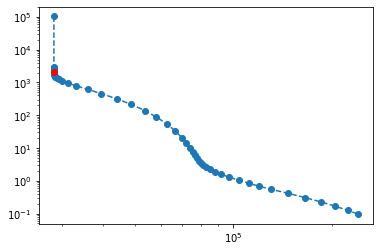

In [50]:
plt.loglog(*fsvals.T, 'o--',)
plt.loglog(*fsvals[35], 'ro')

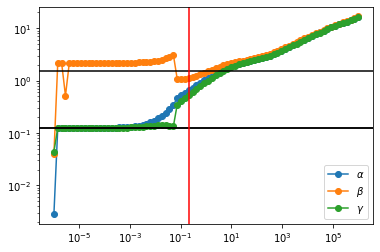

In [64]:
idx = 35
plt.plot(prange, [float(s['x'][-3]) for s in sols], 'o-', label=r'$\alpha$')
plt.plot(prange, [float(s['x'][-2]) for s in sols], 'o-', label=r'$\beta$')
plt.plot(prange, [float(s['x'][-1]) for s in sols], 'o-', label=r'$\gamma$')
for q in p0:
    plt.axhline(q, color='k')
plt.xscale('log')
plt.yscale('log')
plt.axvline(prange[idx], color='r')
plt.legend()

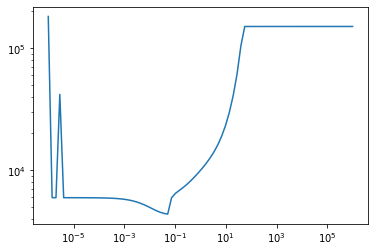

In [17]:
getN = lambda idx: np.mean(np.hstack([np.array(x) for x in getx(sols[idx]['x'])]).sum(axis=1))
plt.loglog(prange, [getN(i) for i,_ in enumerate(prange)])

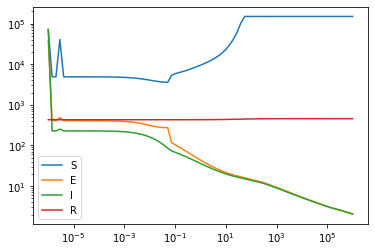

In [18]:
getM = lambda idx: np.mean(np.hstack([np.array(x) for x in getx(sols[idx]['x'])]), axis=0)
plt.semilogx(prange, [getM(i) for i,_ in enumerate(prange)])
plt.yscale('log')
plt.legend("SEIR")

In [19]:
# applying the final size relation
from scipy.optimize import brentq
def rinf(sol):
    pfin = np.array([float(p) for p in getp(sol['x'])])
    r0 = pfin[1]/pfin[0]
    S0, E0, I0, R0 = [float(x[0]) for x in getx(sol['x'])]
    N = sum((S0, E0, I0, R0))
    f = lambda y: y/S0 - np.exp(r0*(y-N)/N) 
    sinf = brentq(f, 0, S0) 
    return N-sinf

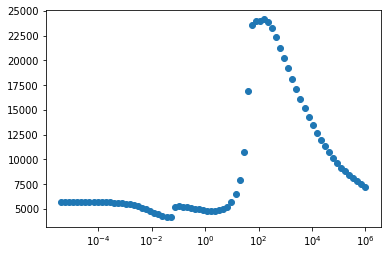

In [29]:
plt.semilogx(prange[4:], [rinf(sol) for sol in sols][4:], 'o')

In [53]:
rinf(sols[35])

5168.799862025806

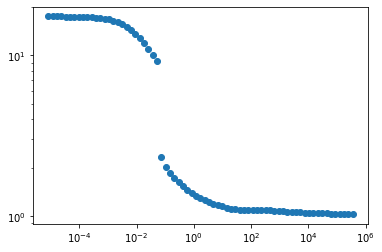

In [22]:
def r0(sol):
    pfin = np.array([float(p) for p in getp(sol['x'])])
    return pfin[1]/pfin[0]
plt.plot(prange[6:-3], [r0(sol) for sol in sols][6:-3], 'o')
plt.xscale('log')
plt.yscale('log')

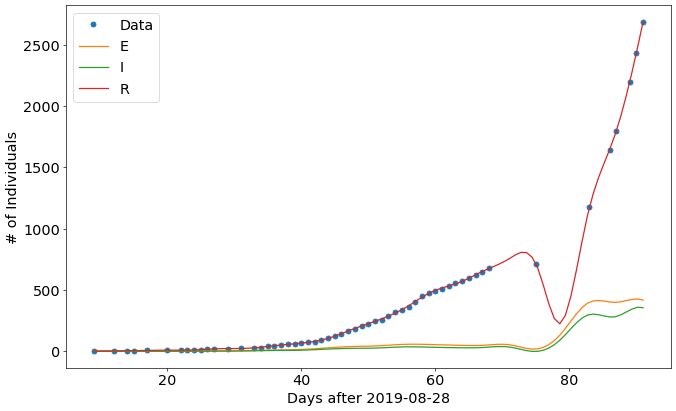

In [63]:
idx=35
fig, ax=plt.subplots(figsize=[13, 8], dpi=60)
ax.plot(times, cumdata, 'o', label='Data')
# ax.plot(model.observation_times, getx(sols[idx]['x'])[0], label='S')
ax.plot(model.observation_times, getx(sols[idx]['x'])[1], label='E')
ax.plot(model.observation_times, getx(sols[idx]['x'])[2], label='I')
ax.plot(model.observation_times, getx(sols[idx]['x'])[3], label='R')
ax.legend(fontsize='xx-large')
ax.set_xlabel(f'Days after {cases["Date"][0].date()}',size='xx-large')
ax.set_ylabel('# of Individuals',size='xx-large')
ax.tick_params(labelsize='xx-large')

In [55]:
getp(sols[idx]['x'])

(DM(0.653969), DM(1.13183), DM(0.524385))

In [59]:
[getx(sols[idx]['x'])[i][50] for i in range(4)]

[DM(7005.29), DM(43.2985), DM(26.2086), DM(233.77)]

In [65]:
getx(sols[idx]['x'])[0][0]

DM(7328.47)